In [1]:
import h5py
import core.init as init
import core.utility as utility
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv as jv
import cycler

# Part to change plotting system
# Slows things down a little but makes nicer plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,6)
plt.rc('font',family='serif')
plt.rcParams.update({'font.size': 24})
plt.rc('text', usetex=True)
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# Parameters
L = 24                          # Linear system size
dim = 1                         # Spatial dimension
n = L**dim                      # Total number of sites
species = 'spinless fermion'    # Type of particle
dsymm = 'charge'                # Type of disorder (spinful fermions only)
Ulist = [0.1]
# List of interaction strengths
J = 1.0                         # Nearest-neighbour hopping amplitude
cutoff = J*10**(-3)             # Cutoff for the off-diagonal elements to be considered zero
dis = [0.7+0.05*i for i in range(11)]
# List of disorder strengths
lmax = 500                      # Flow time max
qmax = 2500                     # Max number of flow time steps
reps = 1                        # Number of disorder realisations
norm = False                    # Normal-ordering, can be true or false
intr = True                     # Turn on/off interactions
dyn = False
imbalance = True                # Sets whether to compute global imbalance or single-site dynamics
LIOM = 'bck'                    # Compute LIOMs with forward ('fwd') or backward ('bck') flow
                                # Forward uses less memory by a factor of qmax, and transforms a local operator
                                # in the initial basis into the diagonal basis; backward does the reverse
dis_type = 'linear'             # Options: 'random', 'QPgolden', 'QPsilver', 'QPbronze', 'QPrandom', 'linear', 'curved', 'prime'
                                # Also contains 'test' and 'QPtest', potentials that do not change from run to run
xlist = [0.1*i for i in range(1,10)]
# For 'dis_type = curved', controls the gradient of the curvature
if intr == False:               # Zero the interactions if set to False (for ED comparison and filename)
    delta = 0
if dis_type != 'curved':
    xlist = [0.0]

# Make directory to store data
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)


## Analytic Solution for Linear Slope

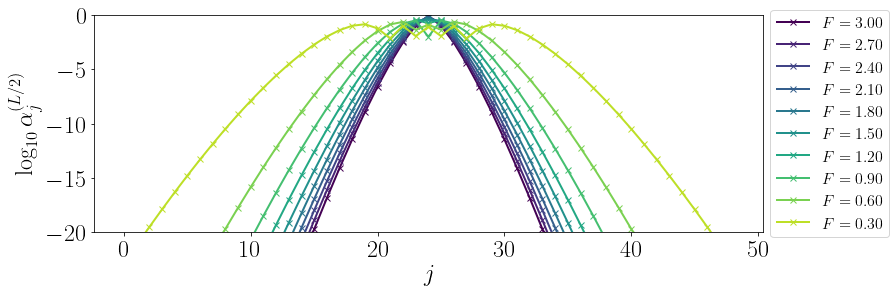

In [3]:
nc = 11
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
mpl.rcParams['figure.figsize'] = (12,4)
plt.rc('font',family='serif')
plt.rcParams.update({'font.size': 24})

n=24
for d in [0.3*i for i in range(1,11)][::-1]:
    bessel = np.zeros(2*n+1)
    for i in range(2*n+1):
        bessel[i] = np.log10(np.abs(jv(np.abs(i-n),2/d)**2))
    plt.plot(bessel,'x-',linewidth='2',label=r'$F = %.2f$' %d)
plt.legend(loc='center right',bbox_to_anchor=(1.2,.5),fontsize=16)
plt.ylim(-20,0)
plt.ylabel(r'$\log_{10} \alpha^{(L/2)}_j$')
plt.xlabel(r'$j$')
plt.savefig('bessel.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

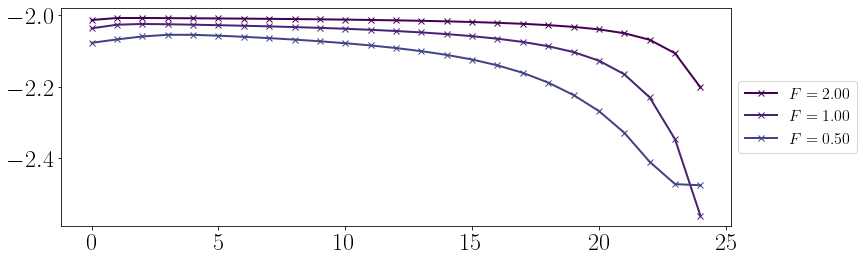

In [12]:
nc = 11
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
mpl.rcParams['figure.figsize'] = (12,4)
plt.rc('font',family='serif')
plt.rcParams.update({'font.size': 24})

n=12
for d in [0.5,1.0,2.0][::-1]:
    bessel = np.zeros((2*n+1,2*n+1))
    for k in range(2*n+1):
        for l in range(2*n+1):
            for i in range(2*n+1):
                for j in range(2*n+1):
                    bessel[l,k] += np.conj(jv(np.abs(i-k),2/d))*jv(np.abs(i-k),2/d)*np.conj(jv(np.abs(j-l),2/d))*jv(np.abs(j-l),2/d)
    bessel2 = np.zeros(2*n+1)
    for i in range(2*n+1):
        bessel2[i] = 0.01*np.mean(np.diag(bessel,i))
        
    plt.plot(np.log10(np.abs(bessel2)),'x-',linewidth='2',label=r'$F = %.2f$' %d)
plt.legend(loc='center right',bbox_to_anchor=(1.2,.5),fontsize=16)
# plt.ylim(-20,0)
# plt.ylabel(r'$\log_{10} \alpha^{(L/2)}_j$')
# plt.xlabel(r'$j$')
# plt.savefig('bessel.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

## Comparison of Numerical and Analytical Solutions

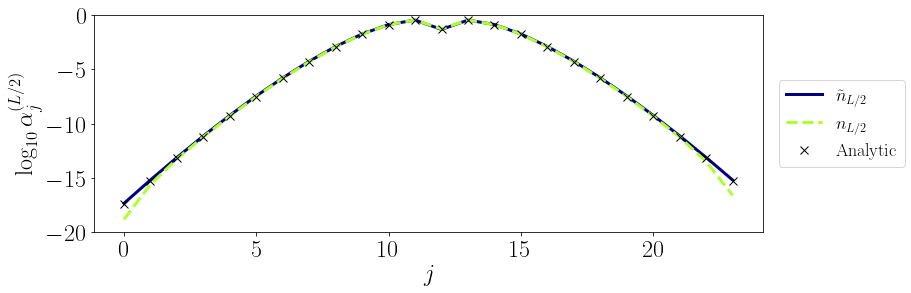

In [5]:
dis = [1.]
xlist = [0.0]
dis_type='linear'
n = 24

norm = False
LIOM = 'bck'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                liom = np.array(hf.get('liom'))
                liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
            plt.plot(liom,label=r'$\tilde{n}_{L/2}$',color='navy',linewidth='3')
            
LIOM = 'fwd'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                liom = np.array(hf.get('liom'))
                liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
            plt.plot(liom,'--',label='$n_{L/2}$',color='greenyellow',linewidth='3')
   
# norm = True
# LIOM = 'bck'
# nvar = utility.namevar(dis_type,dsymm,dyn,norm,n,LIOM,species)
# for d in dis:
#     for x in xlist:
#         for delta in Ulist:
#             with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
#                 liom = np.array(hf.get('liom'))
#                 liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
#             plt.plot(liom,'r')
            
# LIOM = 'fwd'
# nvar = utility.namevar(dis_type,dsymm,dyn,norm,n,LIOM,species)
# for d in dis:
#     for x in xlist:
#         for delta in Ulist:
#             with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
#                 liom = np.array(hf.get('liom'))
#                 liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
#             plt.plot(liom,'r--')
            

bessel = np.zeros(n)
for i in range(n):
    bessel[i] = np.log10(np.abs(jv(np.abs(i-n//2),2)**2))
plt.plot(bessel,'kx',markersize='8',label=r'Analytic')
plt.legend(loc='center right',bbox_to_anchor=(1.225,.5),fontsize=18)
plt.ylim(-20,0)
plt.ylabel(r'$\log_{10} \alpha^{(L/2)}_j$')
plt.xlabel(r'$j$')
plt.savefig('bessel2.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()
norm = False

## Summary of results for linear slope

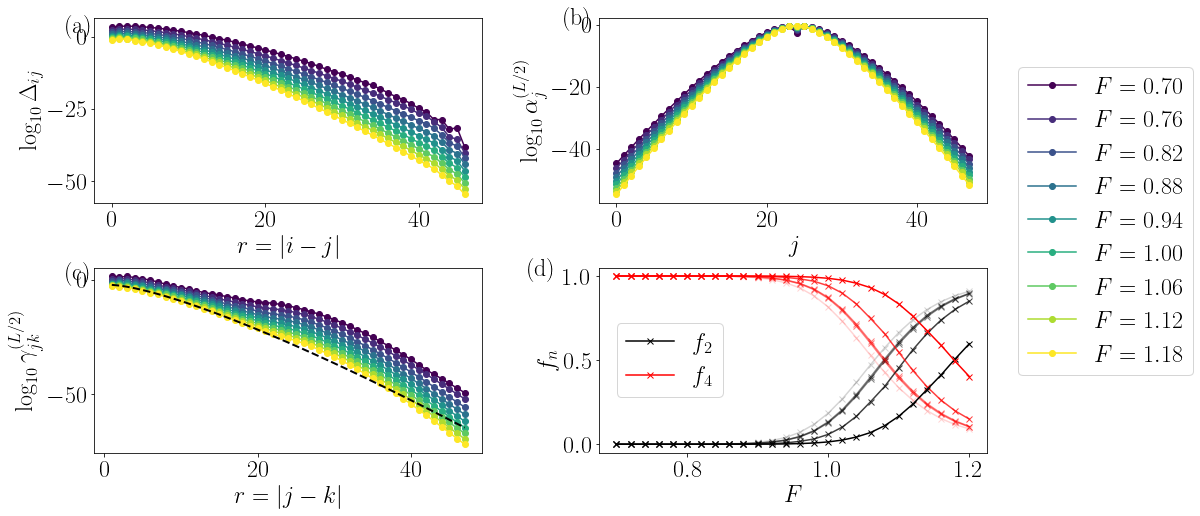

In [17]:
mpl.rcParams['figure.figsize'] = (16,8)

nc = 9
color = plt.cm.viridis(np.linspace(0, 1,nc))

fig, axes = plt.subplots(2,2)
ax1,ax2 = axes[0]
bx1,bx2 = axes[1]

mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
mpl.rcParams['figure.figsize'] = (12,4)
plt.rc('font',family='serif')
plt.rcParams.update({'font.size': 24})

n = 48
dis = [0.7+0.06*i for i in range(9)]
xlist = [0.0]
LIOM = 'bck'
norm = False
species = 'spinless fermion'
dis_type = 'linear'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                lbits = np.array(hf.get('lbits'))
                error = np.array(hf.get('err'))
#                 print(d,np.mean(error))
            ax1.plot(lbits,'o-')
# plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
ax1.text(-6.,1.5,r'(a)')
ax1.set(ylabel=r'$\log_{10} \Delta_{ij}$',xlabel=r'$r=|i-j|$')
# plt.ylabel(r'$\log_{10} \Delta_{ij}$')
# plt.xlabel(r'$r=|i-j|$')
# plt.show()
# plt.close()

# bessel = np.zeros(n)
# for i in range(n):
#     bessel[i] = np.log10(0.1*np.abs(jv(np.abs(i),2/d)**(3/2)))
# ax1.plot(bessel,'k--',markersize='8',linewidth='2')

# bessel = np.zeros(n)
# for i in range(n):
#     bessel[i] = np.log10(np.abs(jv(np.abs(i-n//2),2/d)**2))
# ax2.plot(bessel,'kx-',markersize='8',linewidth='3',label=r'$\alpha=0.00$',zorder=30)

for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                liom = np.array(hf.get('liom'))
#                 print(d,np.trace(liom[:n**2].reshape(n,n)))
                liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
                
            ax2.plot(liom,'o-',label=r'$F= %.2f$' %d)
            
ax2.text(-7,-0.,r'(b)')
ax2.set(ylabel=r'$\log_{10} \alpha^{(L/2)}_j$',xlabel=r'$j$')

for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                liom = np.array(hf.get('liom'))
                Hint = np.array(hf.get('Hint'))
            l4 = liom[n**2:n**2+n**4].reshape(n,n,n,n)
            Hint = Hint.reshape(n,n,n,n)
            

            mat = np.ones((n,n))    
            
            for i in range(n):              
                for j in range(n):
                    if i != j:
                        # Load dHint_diag with diagonal values (n_i n_j or c^dag_i c_j c^dag_j c_i)
                        mat[i,j] = l4[i,i,j,j]
                        mat[i,j] = -l4[i,j,j,i]
                        Hint[i,i,j,j] = 0.
                        Hint[i,j,j,i] = 0
            l4_list = np.zeros(n-1)
            Hint = Hint.reshape(n**4)
#             print(np.sort(np.abs(Hint))[-30:])
            for k in range(1,n):
                l4_list[k-1] = np.mean(np.abs(np.diag(mat,k)))

        bx1.plot(range(1,n),np.log10(np.abs(l4_list)),'o-')
bx1.set(ylabel=r'$\log_{10} \gamma^{(L/2)}_{jk}$',xlabel=r'$r=|j-k|$') 
bx1.text(-5.,-0.0,r'(c)')
# plt.legend(loc='center right',bbox_to_anchor=(1.3,0.5))
# plt.yscale('log')
# plt.xlabel(r'$r$')
# plt.ylabel(r'$\log_{10} \Delta_{ij}$')
# plt.show()
# plt.close()

bessel = np.zeros(n-1)
for i in range(1,n):
    bessel[i-1] = np.log10(0.01*np.abs(jv(np.abs(i),2/d)))
bx1.plot(range(1,n),bessel,'k--',markersize='8',linewidth='2')


dis = [0.7+0.02*i for i in range(26)]
for n in [8,12,16,24,36,48]:
    
    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)

    f2list = np.zeros(len(dis))
    f4list = np.zeros(len(dis))
    count = 0
    for d in dis:
        for x in xlist:
            for delta in Ulist:
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
                squared = np.sum([i**2 for i in liom])
                f2 = np.sum([i**2 for i in liom[:n**2]])/squared
                f4 = np.sum([i**2 for i in liom[n**2:]])/squared

        f2list[count] = f2
        f4list[count] = f4

        count += 1
        
#     print(n,f2list)
#     print(n,f4list)

    if n == 48:
        bx2.plot(dis,f2list,'kx-',alpha=n/48,label=r'$f_2$')
        bx2.plot(dis,f4list,'rx-',alpha=n/48,label=r'$f_4$')
    else:
        bx2.plot(dis,f2list,'kx-',alpha=n/48)
        bx2.plot(dis,f4list,'rx-',alpha=n/48)
    
bx2.set(ylabel=r'$f_n$',xlabel=r'$F$')
bx2.text(0.575,1.0,r'(d)')
bx2.legend(loc='center right',bbox_to_anchor=(0.35,0.5))
ax2.legend(loc='center left',bbox_to_anchor=(1.05,-0.1))
# plt.tight_layout()
plt.subplots_adjust(hspace=0.35,wspace=0.3)
plt.savefig('linear.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

fermion/data/linear/PT/fwd/static/dataN8
fermion/data/linear/PT/fwd/static/dataN12
fermion/data/linear/PT/fwd/static/dataN24
fermion/data/linear/PT/fwd/static/dataN36
fermion/data/linear/PT/fwd/static/dataN48


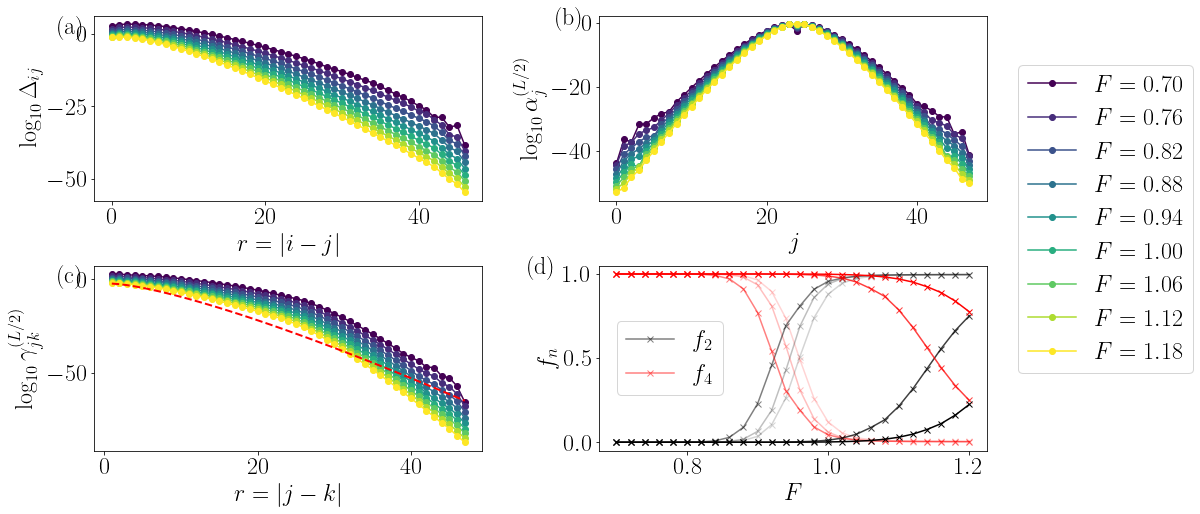

In [5]:
mpl.rcParams['figure.figsize'] = (16,8)

nc = 9
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

fig, axes = plt.subplots(2,2)
ax1,ax2 = axes[0]
bx1,bx2 = axes[1]

mpl.rcParams['figure.figsize'] = (12,4)
plt.rc('font',family='serif')
plt.rcParams.update({'font.size': 24})

n = 48
dis = [0.7+0.06*i for i in range(9)]
xlist = [0.0]
LIOM = 'fwd'
norm = False
species = 'spinless fermion'
dis_type = 'linear'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                lbits = np.array(hf.get('lbits'))
                error = np.array(hf.get('err'))
#                 print(d,np.mean(error))
            ax1.plot(lbits,'o-')
# plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
ax1.text(-7,-0.0,r'(a)')
ax1.set(ylabel=r'$\log_{10} \Delta_{ij}$',xlabel=r'$r=|i-j|$')
# plt.ylabel(r'$\log_{10} \Delta_{ij}$')
# plt.xlabel(r'$r=|i-j|$')
# plt.show()
# plt.close()


# bessel = np.zeros(n)
# for i in range(n):
#     bessel[i] = np.log10(0.1*np.abs(jv(np.abs(i),2/d)**(3/2)))
# ax1.plot(bessel,'k--',markersize='8',linewidth='2')


# bessel = np.zeros(n)
# for i in range(n):
#     bessel[i] = np.log10(np.abs(jv(np.abs(i-n//2),2/d)**2))
# ax2.plot(bessel,'kx-',markersize='8',linewidth='3',label=r'$\alpha=0.00$',zorder=30)

for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                liom = np.array(hf.get('liom'))
#                 print(d,np.trace(liom[:n**2].reshape(n,n)))
                liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
                
            ax2.plot(liom,'o-',label=r'$F= %.2f$' %d)
            
ax2.text(-8,-0.75,r'(b)')
ax2.set(ylabel=r'$\log_{10} \alpha^{(L/2)}_j$',xlabel=r'$j$')

for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                liom = np.array(hf.get('liom'))
            l4 = liom[n**2:n**2+n**4].reshape(n,n,n,n)

            mat = np.ones((n,n))    
            for i in range(n):              
                for j in range(n):
                    if i != j:
                        # Load dHint_diag with diagonal values (n_i n_j or c^dag_i c_j c^dag_j c_i)
                        mat[i,j] = l4[i,i,j,j]
                        mat[i,j] = -l4[i,j,j,i]
            l4_list = np.zeros(n-1)
            for k in range(1,n):
                l4_list[k-1] = np.mean(np.abs(np.diag(mat,k)))

        bx1.plot(range(1,n),np.log10(np.abs(l4_list)),'o-')
bx1.set(ylabel=r'$\log_{10} \gamma^{(L/2)}_{jk}$',xlabel=r'$r=|j-k|$') 
bx1.text(-6,-1.8,r'(c)')
# plt.legend(loc='center right',bbox_to_anchor=(1.3,0.5))
# plt.yscale('log')
# plt.xlabel(r'$r$')
# plt.ylabel(r'$\log_{10} \Delta_{ij}$')
# plt.show()
# plt.close()

bessel = np.zeros(n-1)
for i in range(1,n):
    bessel[i-1] = np.log10((0.01*np.abs(jv(np.abs(i),2/d)))**(1))
bx1.plot(range(1,n),bessel,'r--',markersize='8',linewidth='2')

dis = [0.7+0.02*i for i in range(26)]
for n in [8,12,24,36,48]:
    
    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
    print(nvar)

    f2list = np.zeros(len(dis))
    f4list = np.zeros(len(dis))
    count = 0
    for d in dis:
        for x in xlist:
            for delta in Ulist:
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
                squared = np.sum([i**2 for i in liom])
                f2 = np.sum([i**2 for i in liom[:n**2]])/squared
                f4 = np.sum([i**2 for i in liom[n**2:]])/squared

        f2list[count] = f2
        f4list[count] = f4

        count += 1
        
#     print(n,f2list)
#     print(n,f4list)

    if n == 24:
        bx2.plot(dis,f2list,'kx-',alpha=n/48,label=r'$f_2$')
        bx2.plot(dis,f4list,'rx-',alpha=n/48,label=r'$f_4$')
    else:
        bx2.plot(dis,f2list,'kx-',alpha=n/48)
        bx2.plot(dis,f4list,'rx-',alpha=n/48)
    
bx2.set(ylabel=r'$f_n$',xlabel=r'$F$')
bx2.text(0.575,1.0,r'(d)')
bx2.legend(loc='center right',bbox_to_anchor=(0.35,0.5))
ax2.legend(loc='center left',bbox_to_anchor=(1.05,-0.1))
# plt.tight_layout()
plt.subplots_adjust(hspace=0.35,wspace=0.3)
plt.savefig('linear_fwd.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

## Comparison of 'forward' and 'backward' LIOMs

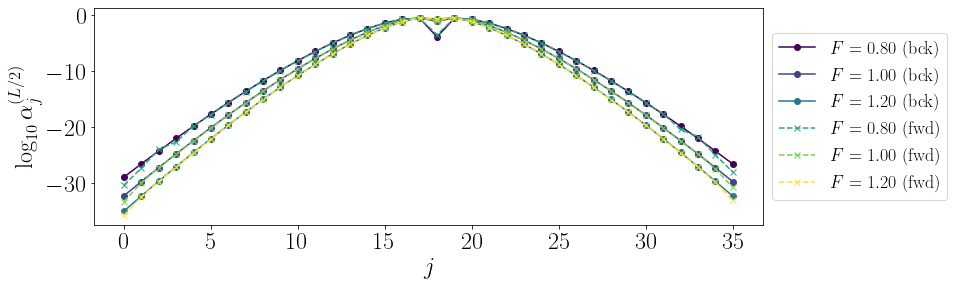

In [9]:
n=36
dis = [0.8,1.00,1.2]
nc = 6
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

LIOM = 'bck'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                liom = np.array(hf.get('liom'))
                liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
            plt.plot(liom,'o-',label=r'$F = %.2f$ (bck)' %d)
            
LIOM = 'fwd'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                liom = np.array(hf.get('liom'))
                liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
            plt.plot(liom,'x--',label=r'$F = %.2f$ (fwd)' %d)
            
plt.ylabel(r'$\log_{10} \alpha^{(L/2)}_j$')
plt.xlabel(r'$j$')
plt.legend(loc='center left',bbox_to_anchor=(1.0,0.5),fontsize=18)
plt.show()
plt.close()

## Summary of results for curved potential

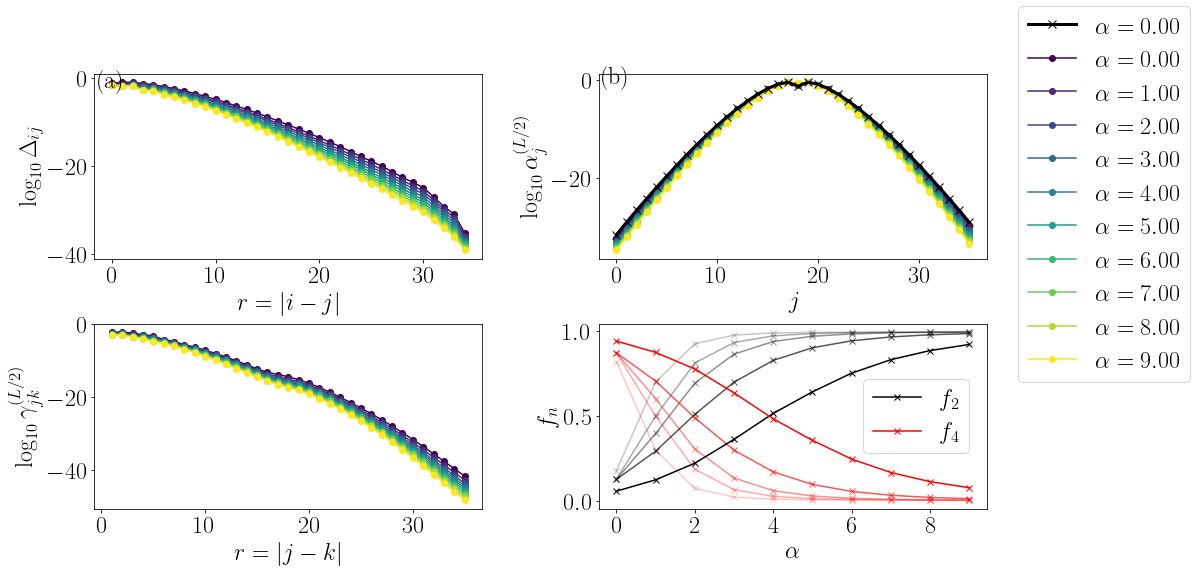

In [9]:
mpl.rcParams['figure.figsize'] = (16,8)

fig, axes = plt.subplots(2,2)
ax1,ax2 = axes[0]
bx1,bx2 = axes[1]

nc = 10
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
mpl.rcParams['figure.figsize'] = (12,4)
plt.rc('font',family='serif')
plt.rcParams.update({'font.size': 24})

n = 36
dis = [1.0]
xlist = [1.0*i for i in range(10)]
LIOM = 'bck'
norm = False
species = 'spinless fermion'
dis_type = 'curved'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            if x == 0.0:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    lbits = np.array(hf.get('lbits'))
                    error = np.array(hf.get('err'))
            else:
                dis_type='curved'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    lbits = np.array(hf.get('lbits'))
                    error = np.array(hf.get('err'))
#                 print(d,np.mean(error))
            ax1.plot(lbits,'o-')
# plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
ax1.text(-1.3,-2.0,r'(a)')
ax1.set(ylabel=r'$\log_{10} \Delta_{ij}$',xlabel=r'$r=|i-j|$')
# plt.ylabel(r'$\log_{10} \Delta_{ij}$')
# plt.xlabel(r'$r=|i-j|$')
# plt.show()
# plt.close()

bessel = np.zeros(n)
for i in range(n):
    bessel[i] = np.log10(np.abs(jv(np.abs(i-n//2),2/d)**2))
ax2.plot(bessel,'kx-',markersize='8',linewidth='3',label=r'$\alpha=0.00$',zorder=30)

for d in dis:
    for x in xlist:
        for delta in Ulist:
            if x == 0.0:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
            else:
                dis_type='curved'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
#                 print(d,np.trace(liom[:n**2].reshape(n,n)))
            liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
                
            ax2.plot(liom,'o-',label=r'$\alpha= %.2f$' %x)
            
ax2.text(-1.4,-0.75,r'(b)')
ax2.set(ylabel=r'$\log_{10} \alpha^{(L/2)}_j$',xlabel=r'$j$')

for d in dis:
    for x in xlist:
        for delta in Ulist:
            if x == 0.0:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
            else:
                dis_type='curved'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
            l4 = liom[n**2:n**2+n**4].reshape(n,n,n,n)

            mat = np.ones((n,n))    
            for i in range(n):              
                for j in range(n):
                    if i != j:
                        # Load dHint_diag with diagonal values (n_i n_j or c^dag_i c_j c^dag_j c_i)
                        mat[i,j] = l4[i,i,j,j]
                        mat[i,j] = -l4[i,j,j,i]
            l4_list = np.zeros(n-1)
            for k in range(1,n):
                l4_list[k-1] = np.mean(np.abs(np.diag(mat,k)))

        bx1.plot(range(1,n),np.log10(np.abs(l4_list)),'o-')
bx1.set(ylabel=r'$\log_{10} \gamma^{(L/2)}_{jk}$',xlabel=r'$r=|j-k|$') 
# plt.legend(loc='center right',bbox_to_anchor=(1.3,0.5))
# plt.yscale('log')
# plt.xlabel(r'$r$')
# plt.ylabel(r'$\log_{10} \Delta_{ij}$')
# plt.show()
# plt.close()


for n in [8,12,16,24,36]:

    f2list = np.zeros(len(xlist))
    f4list = np.zeros(len(xlist))
    count = 0
    for d in dis:
        for x in xlist:
            for delta in Ulist:
                if x == 0.0:
                    dis_type = 'linear'
                    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                    with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                        liom = np.array(hf.get('liom'))
                else:
                    dis_type='curved'
                    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                    with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                        liom = np.array(hf.get('liom'))
                squared = np.sum([i**2 for i in liom])
                f2 = np.sum([i**2 for i in liom[:n**2]])/squared
                f4 = np.sum([i**2 for i in liom[n**2:]])/squared

            f2list[count] = f2
            f4list[count] = f4

            count += 1

    if n == 36:
        bx2.plot(xlist,f2list,'kx-',alpha=n/36,label=r'$f_2$')
        bx2.plot(xlist,f4list,'rx-',alpha=n/36,label=r'$f_4$')
    else:
        bx2.plot(xlist,f2list,'kx-',alpha=n/36)
        bx2.plot(xlist,f4list,'rx-',alpha=n/36)
    
bx2.set(ylabel=r'$f_n$',xlabel=r'$\alpha$')
bx2.legend(loc='center left',bbox_to_anchor=(0.65,0.5))
ax2.legend(loc='center left',bbox_to_anchor=(1.05,0.35))
# plt.tight_layout()
plt.subplots_adjust(hspace=0.35,wspace=0.3)
plt.savefig('curved.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

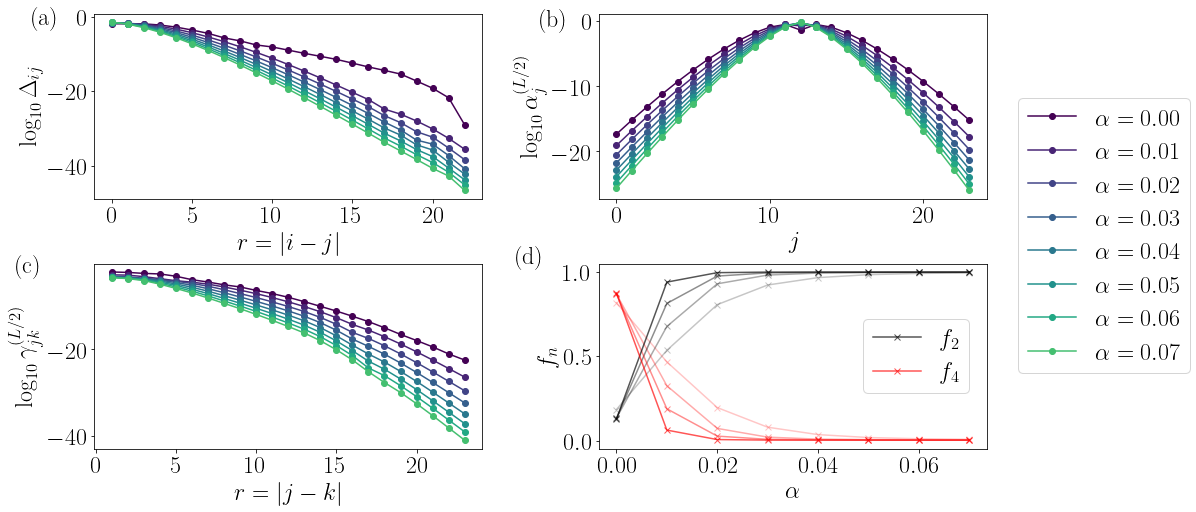

In [38]:
mpl.rcParams['figure.figsize'] = (16,8)

fig, axes = plt.subplots(2,2)
ax1,ax2 = axes[0]
bx1,bx2 = axes[1]

nc = 11
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
mpl.rcParams['figure.figsize'] = (12,4)
plt.rc('font',family='serif')
plt.rcParams.update({'font.size': 24})

n = 24
dis = [1.0]
xlist = [0.01*i for i in range(8)]
LIOM = 'bck'
norm = False
species = 'spinless fermion'
dis_type = 'curved2'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            if x == 0.0:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    lbits = np.array(hf.get('lbits'))
                    error = np.array(hf.get('err'))
            else:
                dis_type='curved2'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    lbits = np.array(hf.get('lbits'))
                    error = np.array(hf.get('err'))
#                 print(d,np.mean(error))
            ax1.plot(lbits,'o-')
# plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
ax1.set(ylabel=r'$\log_{10} \Delta_{ij}$',xlabel=r'$r=|i-j|$')
# plt.ylabel(r'$\log_{10} \Delta_{ij}$')
# plt.xlabel(r'$r=|i-j|$')
# plt.show()
# plt.close()

# bessel = np.zeros(n)
# for i in range(n):
#     bessel[i] = np.log10(np.abs(jv(np.abs(i-n//2),2/d)**2))
# ax2.plot(bessel,'kx-',markersize='8',linewidth='3',label=r'$\alpha=0.00$',zorder=30)

for d in dis:
    for x in xlist:
        for delta in Ulist:
            if x == 0.0:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
            else:
                dis_type='curved2'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
#                 print(d,np.trace(liom[:n**2].reshape(n,n)))
            liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
                
            ax2.plot(liom,'o-',label=r'$\alpha= %.2f$' %x)
            
ax2.set(ylabel=r'$\log_{10} \alpha^{(L/2)}_j$',xlabel=r'$j$')

for d in dis:
    for x in xlist:
        for delta in Ulist:
            if x == 0.0:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
            else:
                dis_type='curved2'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
            l4 = liom[n**2:n**2+n**4].reshape(n,n,n,n)

            mat = np.ones((n,n))    
            for i in range(n):              
                for j in range(n):
                    if i != j:
                        # Load dHint_diag with diagonal values (n_i n_j or c^dag_i c_j c^dag_j c_i)
                        mat[i,j] = l4[i,i,j,j]
                        mat[i,j] = -l4[i,j,j,i]
            l4_list = np.zeros(n-1)
            for k in range(1,n):
                l4_list[k-1] = np.mean(np.abs(np.diag(mat,k)))

        bx1.plot(range(1,n),np.log10(np.abs(l4_list)),'o-')
bx1.set(ylabel=r'$\log_{10} \gamma^{(L/2)}_{jk}$',xlabel=r'$r=|j-k|$') 
# plt.legend(loc='center right',bbox_to_anchor=(1.3,0.5))
# plt.yscale('log')
# plt.xlabel(r'$r$')
# plt.ylabel(r'$\log_{10} \Delta_{ij}$')
# plt.show()
# plt.close()


for n in [8,12,16,24]:

    f2list = np.zeros(len(xlist))
    f4list = np.zeros(len(xlist))
    count = 0
    for d in dis:
        for x in xlist:
            for delta in Ulist:
                if x == 0.0:
                    dis_type = 'linear'
                    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                    with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                        liom = np.array(hf.get('liom'))
                else:
                    dis_type='curved2'
                    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                    with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                        liom = np.array(hf.get('liom'))
                squared = np.sum([i**2 for i in liom])
                f2 = np.sum([i**2 for i in liom[:n**2]])/squared
                f4 = np.sum([i**2 for i in liom[n**2:]])/squared
            f2list[count] = f2
            f4list[count] = f4

            count += 1

    if n == 24:
        bx2.plot(xlist,f2list,'kx-',alpha=n/36,label=r'$f_2$')
        bx2.plot(xlist,f4list,'rx-',alpha=n/36,label=r'$f_4$')
    else:
        bx2.plot(xlist,f2list,'kx-',alpha=n/36)
        bx2.plot(xlist,f4list,'rx-',alpha=n/36)
    
ax1.text(-5.,-2.0,r'(a)')
ax2.text(-5.,-0.75,r'(b)')
bx1.text(-5.,-2.0,r'(c)')
bx2.text(-0.02,1.05,r'(d)')
bx2.set(ylabel=r'$f_n$',xlabel=r'$\alpha$')
bx2.legend(loc='center left',bbox_to_anchor=(0.65,0.5))
ax2.legend(loc='center left',bbox_to_anchor=(1.05,-0.2))
# plt.tight_layout()
plt.subplots_adjust(hspace=0.35,wspace=0.3)
plt.savefig('curved2.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

## Comparison of curved and linear potentials

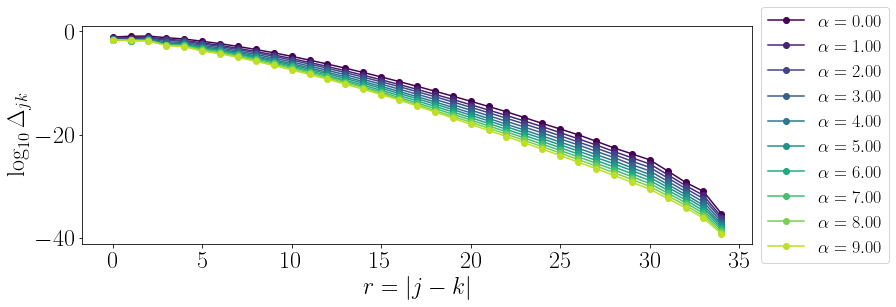

In [17]:
n = 36
dis = [1.00]
xlist = [1.0*i for i in range(10)]
nc = 11
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

LIOM = 'bck'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            
            if x == 0.0:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('lbits'))
#                     liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
                plt.plot(liom,'o-',label=r'$\alpha = %.2f$' %x)
            
            else:
                dis_type = 'curved'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('lbits'))
#                     liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
                plt.plot(liom,'o-',label=r'$\alpha = %.2f$' %x)
            

plt.ylabel(r'$\log_{10} \Delta_{jk}$')
plt.xlabel(r'$r=|j-k|$')
plt.legend(loc='center left',bbox_to_anchor=(1.0,0.5),fontsize=18)
plt.savefig('curved_delta.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

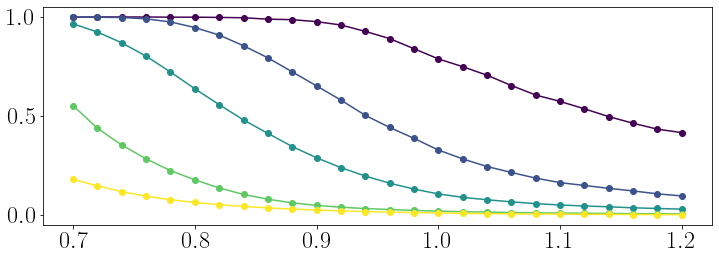

In [19]:
dis = [0.7+0.02*i for i in range(26)]
LIOM = 'bck'
nc = 5
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for n in [8,12,16,24,36]:
    klist = np.zeros(len(dis))
    klist2 = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        count = 0
        count2 = 0
        for x in [0.0]:
            for delta in Ulist:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom')).reshape(n**2+n**4)

                for i in liom:
                    if np.abs(i)>10**(-3):
                        count += 1
                    if np.abs(i)>10**(-6):
                        count2 += 1
        klist[dcount] = count/(n**2+n**4)
        klist2[dcount] = count2/(n**2+n**4)
        dcount += 1
    plt.plot(dis,klist,'o-')
#     plt.plot(dis,klist2,'x--')
# plt.yscale('log')
plt.show()
plt.close()

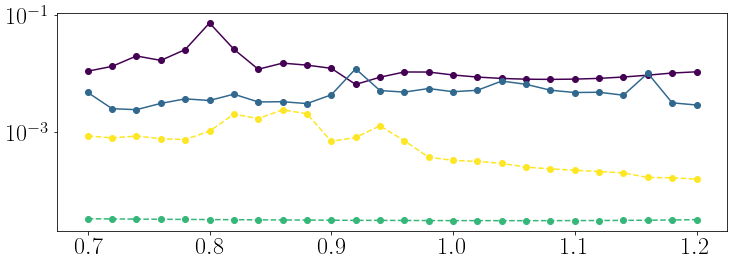

In [15]:
dis = [0.7+0.02*i for i in range(26)]
LIOM = 'bck'

for n in [8,12]:
    errlist = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        for x in [0.0]:
            for delta in Ulist:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    err = np.array(hf.get('err'))
                    Hint = np.array(hf.get('Hint'))
#                     print(d,np.max(np.abs(Hint)))
        errlist[dcount] = np.mean(err)
        dcount += 1
    plt.plot(dis,errlist,'o-')
#     plt.plot(dis,klist2,'x--')
# plt.yscale('log')
# plt.show()
# plt.close()

for n in [8,12]:
    errlist = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        for x in [0.8]:
            for delta in Ulist:
                dis_type = 'curved2'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    err = np.array(hf.get('err'))
                    Hint = np.array(hf.get('Hint'))
#                     print(d,np.max(np.abs(Hint)))
        errlist[dcount] = np.mean(err)
        dcount += 1
    plt.plot(dis,errlist,'o--')
#     plt.plot(dis,klist2,'x--')
plt.yscale('log')
plt.show()
plt.close()

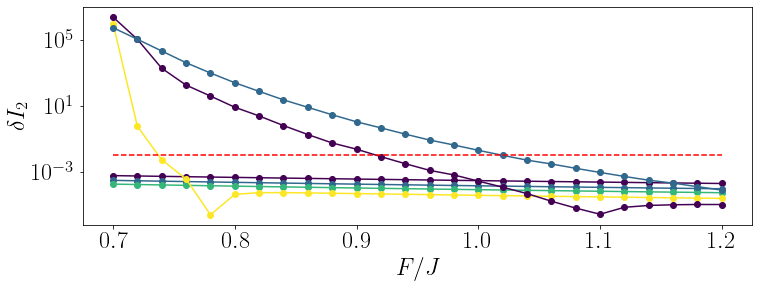

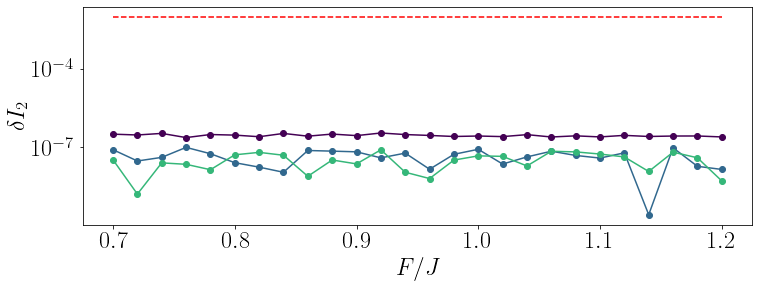

In [13]:
dis = [0.7+0.02*i for i in range(26)]
LIOM = 'bck'

for n in [8,12,16,24,36,48]:
    invlist = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        for x in [0.0]:
            for delta in Ulist:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    inv = np.array(hf.get('inv'))
                    Hint = np.array(hf.get('Hint'))
#                     print(d,np.max(np.abs(Hint)))
        invlist[dcount] = inv
        dcount += 1
    plt.plot(dis,invlist,'o-')
#     plt.plot(dis,klist2,'x--')
plt.plot(dis,0.01*np.ones(len(dis)),'r--')
plt.yscale('log')
plt.xlabel(r'$F/J$')
plt.ylabel(r'$\delta I_2$')
plt.show()
plt.close()

for n in [12,16,24]:
    invlist = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        for x in [0.8]:
            for delta in Ulist:
                dis_type = 'curved2'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    inv = np.array(hf.get('inv'))
                    Hint = np.array(hf.get('Hint'))
#                     print(d,np.max(np.abs(Hint)))
        invlist[dcount] = inv
        dcount += 1
    plt.plot(dis,invlist,'o-')
#     plt.plot(dis,klist2,'x--')
plt.plot(dis,0.01*np.ones(len(dis)),'r--')
plt.yscale('log')
plt.xlabel(r'$F/J$')
plt.ylabel(r'$\delta I_2$')
plt.show()
plt.close()

8 0.0498046875 0.0166015625
12 0.047839506172839504 0.008680555555555556
16 0.04400634765625 0.00445556640625
24 0.03812210648148148 0.0016276041666666667
36 0.03957214029873495 0.002236225422953818
48 0.033932532793209874 0.00202734676408179


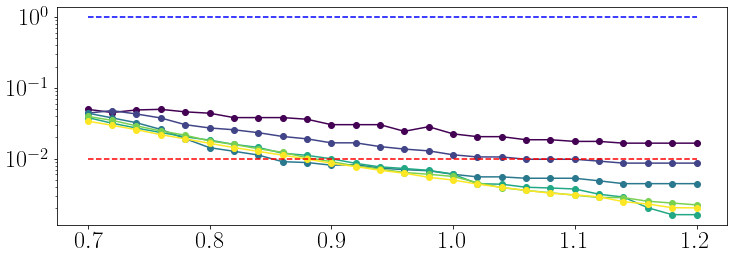

In [78]:
dis = [0.7+0.02*i for i in range(26)]
LIOM = 'bck'
nc = 6
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for n in [8,12,16,24,36,48]:
    klist = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        count = 0
        count2 = 0
        for x in [0.0]:
            for delta in Ulist:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    Hint = np.array(hf.get('Hint'))
                    Hint = Hint.reshape(n,n,n,n)
                for i in range(n):
                    for j in range(n):
                        Hint[i,i,j,j] = 0.
                        Hint[i,j,j,i] = 0.
                        
                qcount = 0
                for q in np.abs(Hint.reshape(n**4)):
                    if q > 0.001:
                        qcount += 1

#         klist[dcount] = np.max(np.abs(Hint))
        klist[dcount] = qcount/n**4
        dcount += 1
    plt.plot(dis,klist,'o-')
    print(n,np.max(klist),np.min(klist))
#     plt.plot(dis,klist2,'x--')
plt.plot(dis,np.ones(len(dis)),'b--')
plt.plot(dis,.01*np.ones(len(dis)),'r--')
plt.yscale('log')
plt.show()
plt.close()

8 118.78236802788035
12 265.2690652102017
24 29257.431779803188
36 5286.742603495835
48 2798.190472386743


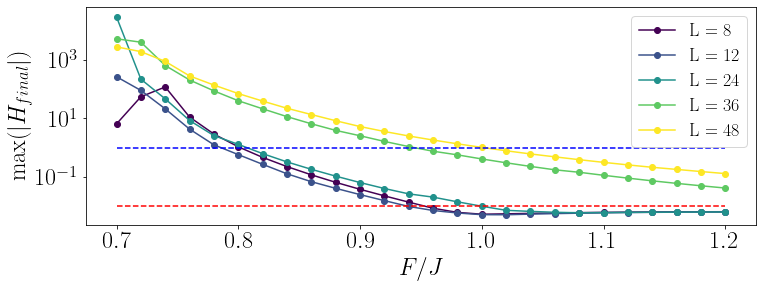

In [26]:
dis = [0.7+0.02*i for i in range(26)]
LIOM = 'bck'
nc = 5
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for n in [8,12,24,36,48]:
    klist = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        count = 0
        count2 = 0
        for x in [0.0]:
            for delta in Ulist:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    Hint = np.array(hf.get('Hint'))
                    Hint = Hint.reshape(n,n,n,n)
                for i in range(n):
                    for j in range(n):
                        Hint[i,i,j,j] = 0.
                        Hint[i,j,j,i] = 0.

        klist[dcount] = np.max(np.abs(Hint))
        dcount += 1
    plt.plot(dis,klist,'o-',label=r'L = %s' %n)
    print(n,np.max(klist))
#     plt.plot(dis,klist2,'x--')
plt.plot(dis,np.ones(len(dis)),'b--')
plt.plot(dis,.01*np.ones(len(dis)),'r--')
plt.legend(fontsize=18)
plt.xlabel(r'$F/J$')
plt.ylabel(r'$\textrm{max}(|H_{final}|)$')
plt.yscale('log')
plt.show()
plt.close()

8 0.003339191773199987
12 0.015668041448127404
16 0.013366573363913609
24 0.004525205925812395


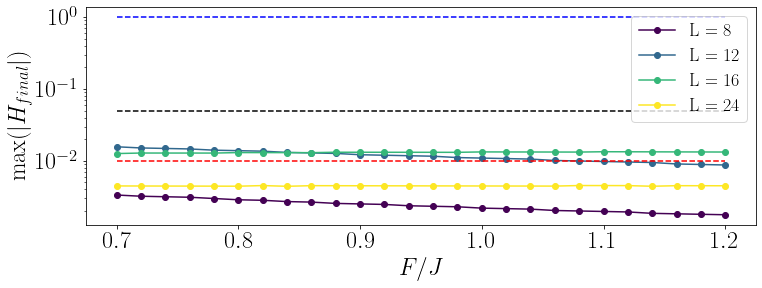

In [7]:
dis = [0.7+0.02*i for i in range(26)]
LIOM = 'bck'
nc = 4
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for n in [8,12,16,24]:
    klist = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        count = 0
        count2 = 0
        for x in [0.8]:
            for delta in Ulist:
                dis_type = 'curved2'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    Hint = np.array(hf.get('Hint'))
                    Hint = Hint.reshape(n,n,n,n)
                for i in range(n):
                    for j in range(n):
                        Hint[i,i,j,j] = 0.
                        Hint[i,j,j,i] = 0.

        klist[dcount] = np.max(np.abs(Hint))
        dcount += 1
    plt.plot(dis,klist,'o-',label=r'L = %s' %n)
    print(n,np.max(klist))
#     plt.plot(dis,klist2,'x--')
plt.plot(dis,np.ones(len(dis)),'b--')
plt.plot(dis,.01*np.ones(len(dis)),'r--')
plt.plot(dis,.05*np.ones(len(dis)),'k--')
plt.legend(fontsize=18)
plt.xlabel(r'$F/J$')
plt.ylabel(r'$\textrm{max}(|H_{final}|)$')
plt.yscale('log')
plt.show()
plt.close()

8 9.856781132348973e-07
12 0.02067320560368371
16 0.4413969087938691


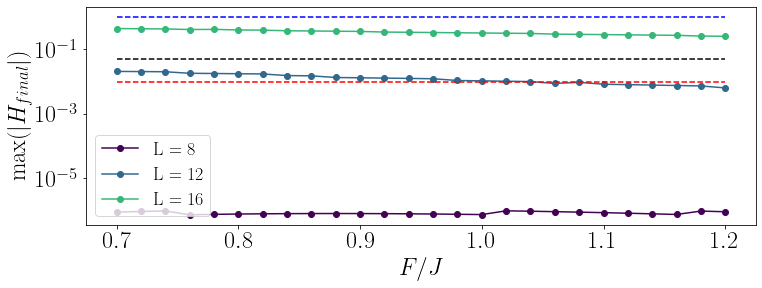

In [24]:
dis = [0.7+0.02*i for i in range(26)]
LIOM = 'bck'
nc = 4
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for n in [8,12,16]:
    klist = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        count = 0
        count2 = 0
        for x in [0.4]:
            for delta in Ulist:
                dis_type = 'curved2'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    H2 = np.array(hf.get('H2_diag'))
                    H2 = H2.reshape(n,n)
                H2 = H2-np.diag(np.diag(H2))

        klist[dcount] = np.max(np.abs(H2))
        dcount += 1
    plt.plot(dis,klist,'o-',label=r'L = %s' %n)
    print(n,np.max(klist))
#     plt.plot(dis,klist2,'x--')
plt.plot(dis,np.ones(len(dis)),'b--')
plt.plot(dis,.01*np.ones(len(dis)),'r--')
plt.plot(dis,.05*np.ones(len(dis)),'k--')
plt.legend(fontsize=18)
plt.xlabel(r'$F/J$')
plt.ylabel(r'$\textrm{max}(|H_{final}|)$')
plt.yscale('log')
plt.show()
plt.close()

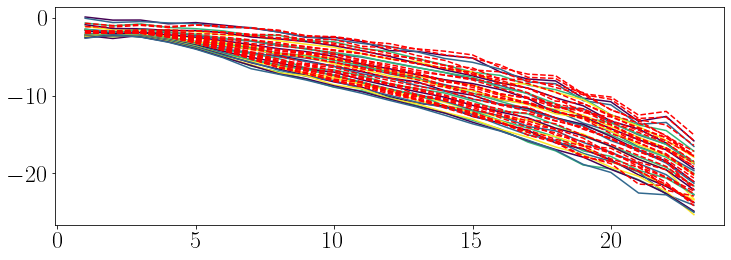

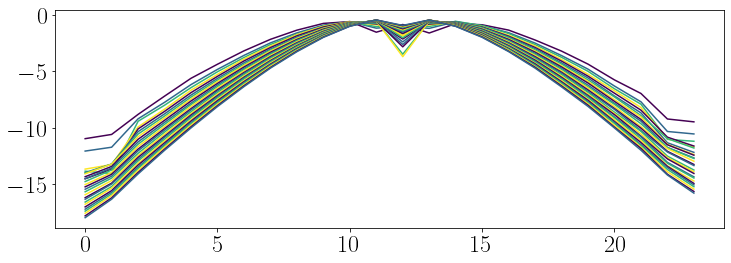

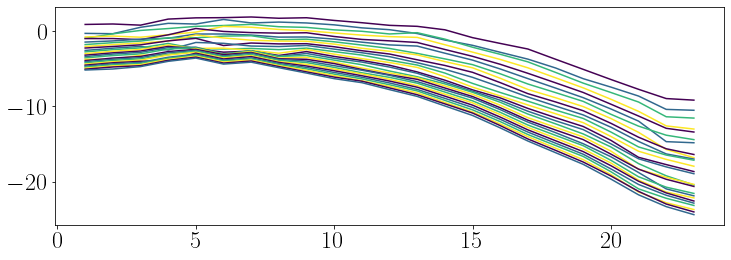

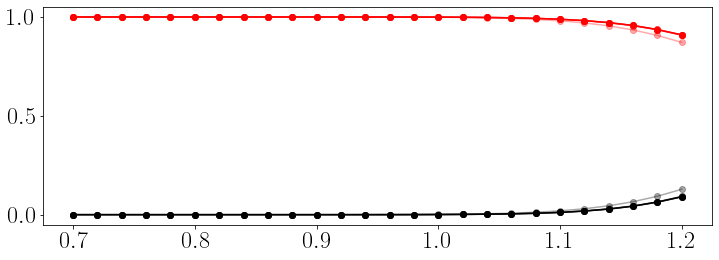

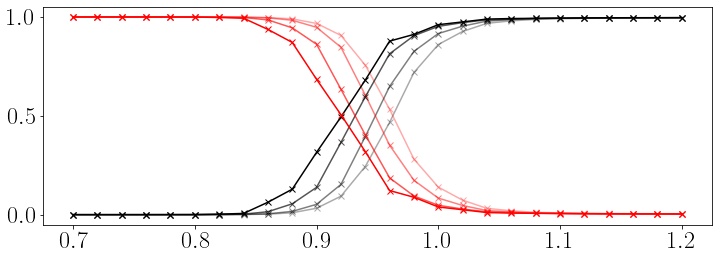

In [58]:
n=24
dlist = [0.7+0.02*i for i in range(26)]
for d in dlist:
    with h5py.File('cuda/linear/dataN%s/tflow-d%.2f-Jz0.10-p0-cutoff3.00.h5' %(n,d),'r') as hf:
        H0 = np.array(hf.get('H0'))
        Hint = np.array(hf.get('Hint'))
        
    V = H0 - np.diag(np.diag(H0))
    if np.max(np.abs(V))>10**(-3):
        print(d,np.max(np.abs(V)))
        
    mat = np.ones((n,n))    
    for i in range(n):              
        for j in range(n):
            if i != j:
                # Load dHint_diag with diagonal values (n_i n_j or c^dag_i c_j c^dag_j c_i)
                mat[i,j] = Hint[i,i,j,j]
                mat[i,j] = -Hint[i,j,j,i]
    int_list = np.zeros(n-1)
    for k in range(1,n):
        int_list[k-1] = np.median(np.log10(np.abs(np.diag(mat,k))))
    
    plt.plot(range(1,n),int_list)
# plt.show()
# plt.close()
            
    
for d in dlist:
    with h5py.File('cuda/linear/dataN%s/tflow-d%.2f-Jz0.10-p0-cutoff3.00.h5' %(n,d),'r') as hf:
        lbits = np.array(hf.get('lbits'))
    
    plt.plot(range(1,n),lbits,'r--')
plt.show()
plt.close()
            

for d in dlist:
    with h5py.File('cuda/linear/dataN%s/tflow-d%.2f-Jz0.10-p0-cutoff3.00.h5' %(n,d),'r') as hf:
        liom = np.array(hf.get('liom_all_bck'))
        l2 = (liom[0:n**2]).reshape(n,n)
    
    plt.plot(range(n),np.log10(np.abs(np.diag(l2))))
plt.show()
plt.close()

for d in dlist:
    with h5py.File('cuda/linear/dataN%s/tflow-d%.2f-Jz0.10-p0-cutoff3.00.h5' %(n,d),'r') as hf:
        liom = np.array(hf.get('liom_all_bck'))
        l4 = (liom[n**2::]).reshape(n,n,n,n)
        
#         print('max',np.max(np.abs(l4)))
        
    mat = np.ones((n,n))    
    for i in range(n):              
        for j in range(n):
            if i != j:
                # Load dHint_diag with diagonal values (n_i n_j or c^dag_i c_j c^dag_j c_i)
                mat[i,j] = l4[i,i,j,j]
                mat[i,j] = -l4[i,j,j,i]
    l4_list = np.zeros(n-1)
    for k in range(1,n):
        l4_list[k-1] = np.median(np.log10(np.abs(np.diag(mat,k))))
    
    plt.plot(range(1,n),l4_list)
plt.show()
plt.close()
            
    
for n in [8,12,16,24]:

    f2list = np.zeros(len(dlist))
    f4list = np.zeros(len(dlist))
    count = 0
    for d in dlist:
        with h5py.File('cuda/linear/dataN%s/tflow-d%.2f-Jz0.10-p0-cutoff3.00.h5' %(n,d),'r') as hf:
            liom = np.array(hf.get('liom_all_bck'))
#         l4 = (liom[n**2::]).reshape(n,n,n,n)
#         print(len(liom[:n**2]),len(liom[n**2:]))
        squared = np.sum([i**2 for i in liom])
        f2 = np.sum([i**2 for i in liom[:n**2]])/squared
        f4 = np.sum([i**2 for i in liom[n**2:]])/squared
        
        f2list[count] = f2
        f4list[count] = f4

        count += 1

# print(f4list)
                
    plt.plot(dlist,f2list,'ok-',alpha=n/24)
    plt.plot(dlist,f4list,'or-',alpha=n/24)
# plt.yscale('log')
plt.show()
plt.close()

for n in [8,12,16,24]:

    f2list = np.zeros(len(dlist))
    f4list = np.zeros(len(dlist))
    count = 0
    for d in dlist:
        with h5py.File('cuda/linear/dataN%s/tflow-d%.2f-Jz0.10-p0-cutoff3.00.h5' %(n,d),'r') as hf:
            liom = np.array(hf.get('liom_all_fwd'))
#         l4 = (liom[n**2::]).reshape(n,n,n,n)
#         print(len(liom[:n**2]),len(liom[n**2:]))
        squared = np.sum([i**2 for i in liom])
        f2 = np.sum([i**2 for i in liom[:n**2]])/squared
        f4 = np.sum([i**2 for i in liom[n**2:]])/squared
        
        f2list[count] = f2
        f4list[count] = f4

        count += 1

# print(f4list)
                
    plt.plot(dlist,f2list,'xk-',alpha=n/24)
    plt.plot(dlist,f4list,'xr-',alpha=n/24)
# plt.yscale('log')
plt.show()
plt.close()

0.7 0.0009959039
0.72 0.0009998566
0.74 0.0009868598
0.76 0.0009863757
0.7799999999999999 0.0009900614
0.7999999999999999 0.0009887485
0.82 0.0009951058
0.84 0.0008773952
0.86 0.00088449114
0.8799999999999999 0.00090327696
0.8999999999999999 0.00093279633
0.9199999999999999 0.000995496
0.94 0.00093074364
0.96 0.0008969682
0.98 0.0009680435
1.0 0.00093472097
1.02 0.0009272052
1.04 0.000890962
1.06 0.0008894865
1.08 0.0009887572
1.1 0.0009928674
1.1199999999999999 0.0009977586
1.14 0.0009839238
[7.53709082e-09 1.26268315e-10 1.20088344e-11 3.92961777e-09
 4.60481725e-08 2.22723378e-07 7.76990137e-07 2.71188352e-06
 7.20812521e-06 1.79239040e-05 4.19886630e-05 9.29057014e-05
 1.95571594e-04 3.93721451e-04 7.62750703e-04 1.41899194e-03
 2.54240309e-03 4.43041095e-03 7.44166435e-03 1.21754209e-02
 1.93335338e-02 2.99203719e-02 4.48488052e-02]
[0.99999999 1.         1.         1.         0.99999995 0.99999978
 0.99999922 0.99999729 0.99999279 0.99998208 0.99995801 0.99990709
 0.99980443 0.99

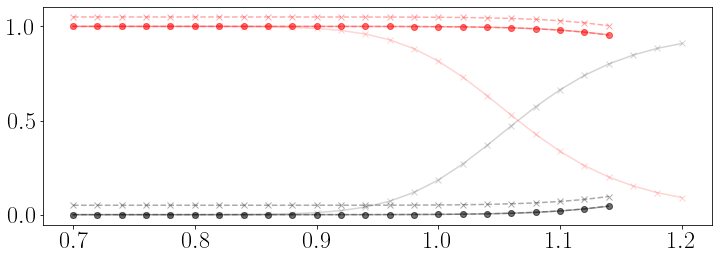

In [82]:
dlist = [0.7+0.02*i for i in range(23)]

for n in [8]:

    f2list = np.zeros(len(dlist))
    f4list = np.zeros(len(dlist))
    count = 0
    for d in dlist:
        with h5py.File('cuda/linear/dataN%s/tflow-d%.2f-Jz0.10-p0-cutoff3.00.h5' %(n,d),'r') as hf:
            liom = np.array(hf.get('liom_all_bck'))
            H = np.array(hf.get('H0'))
            V = H - np.diag(np.diag(H))
            print(d,np.max(np.abs(V)))
#         l4 = (liom[n**2::]).reshape(n,n,n,n)
#         print(len(liom[:n**2]),len(liom[n**2:]))
        squared = np.sum([i**2 for i in liom])
        f2 = np.sum([i**2 for i in liom[:n**2]])/squared
        f4 = np.sum([i**2 for i in liom[n**2:]])/squared
        
        f2list[count] = f2
        f4list[count] = f4

        count += 1

    print(f2list)
    print(f4list)
                
    plt.plot(dlist,f2list,'ok-',alpha=n/24)
    plt.plot(dlist,f4list,'or-',alpha=n/24)
    
for n in [8]:

    f2list = np.zeros(len(dlist))
    f4list = np.zeros(len(dlist))
    count = 0
    for d in dlist:
        with h5py.File('cuda/linear/dataN%s/tflow-d%.2f-Jz0.10-p0-cutoff2.00.h5' %(n,d),'r') as hf:
            liom = np.array(hf.get('liom_all_bck'))
            H = np.array(hf.get('H0'))
            V = H - np.diag(np.diag(H))
            print(d,np.max(np.abs(V)))
#         l4 = (liom[n**2::]).reshape(n,n,n,n)
#         print(len(liom[:n**2]),len(liom[n**2:]))
        squared = np.sum([i**2 for i in liom])
        f2 = np.sum([i**2 for i in liom[:n**2]])/squared
        f4 = np.sum([i**2 for i in liom[n**2:]])/squared
        
        f2list[count] = f2
        f4list[count] = f4

        count += 1

    print(f2list)
    print(f4list)
                
    plt.plot(dlist,f2list,'ok--',alpha=n/24)
    plt.plot(dlist,f4list,'or--',alpha=n/24)
    
for n in [8]:

    f2list = np.zeros(len(dlist))
    f4list = np.zeros(len(dlist))
    count = 0
    for d in dlist:
        with h5py.File('cpu/linear/dataN%s/tflow-d%.2f-Jz0.10-p0-cutoff2.00.h5' %(n,d),'r') as hf:
            liom = np.array(hf.get('liom_all_bck'))
            H = np.array(hf.get('H0'))
            V = H - np.diag(np.diag(H))
            print(d,np.max(np.abs(V)))
#         l4 = (liom[n**2::]).reshape(n,n,n,n)
#         print(len(liom[:n**2]),len(liom[n**2:]))
        squared = np.sum([i**2 for i in liom])
        f2 = np.sum([i**2 for i in liom[:n**2]])/squared
        f4 = np.sum([i**2 for i in liom[n**2:]])/squared
        
        f2list[count] = f2+0.05
        f4list[count] = f4+0.05

        count += 1

    print(f2list)
    print(f4list)
                
    plt.plot(dlist,f2list,'xk--',alpha=n/24)
    plt.plot(dlist,f4list,'xr--',alpha=n/24)
    
for n in [8]:
    
    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)

    f2list = np.zeros(len(dis))
    f4list = np.zeros(len(dis))
    count = 0
    for d in dis:
        for x in xlist:
            for delta in Ulist:
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
                squared = np.sum([i**2 for i in liom])
                f2 = np.sum([i**2 for i in liom[:n**2]])/squared
                f4 = np.sum([i**2 for i in liom[n**2:]])/squared

        f2list[count] = f2
        f4list[count] = f4

        count += 1
        
#     print(n,f2list)
#     print(n,f4list)

    plt.plot(dis,f2list,'kx-',alpha=n/48)
    plt.plot(dis,f4list,'rx-',alpha=n/48)
    
# plt.yscale('log')
plt.show()
plt.close()

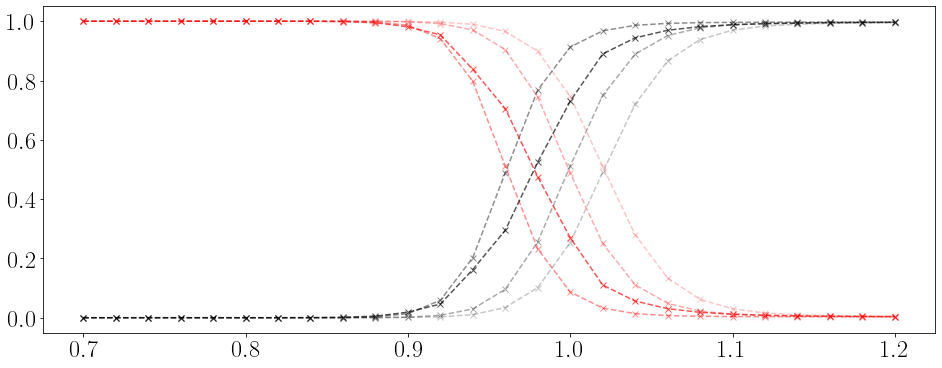

0.7 4.809605485445315e-24
0.72 1.4253073713274974e-24
0.74 5.078951006500952e-24
0.76 7.725522196085718e-25
0.7799999999999999 3.632761088900667e-25
0.7999999999999999 7.3700208991495e-26
0.82 4.710231221742864e-26
0.84 3.183439060871449e-26
0.86 7.620547430836464e-27
0.8799999999999999 5.569861212091227e-27
0.8999999999999999 4.214145352578803e-27
0.9199999999999999 1.0822619506023927e-27
0.94 8.740130847601126e-28
0.96 7.301612698535137e-28
0.98 2.0055672297909405e-28
1.0 1.7909477117858576e-28
1.02 5.14615433267166e-29
1.04 4.9404589139074396e-29
1.06 1.4889176425483382e-29
1.08 1.5374352910371944e-29
1.1 4.9458069842055976e-30
1.1199999999999999 5.539762579482432e-30
1.14 1.823606649885015e-30
1.16 2.1783114607260924e-30
1.18 7.750347327090052e-31
1.2 2.8115745011201698e-31
0.7 0.3689193562872675
0.72 0.46040257096682535
0.74 0.41884251982892967
0.76 0.2938737110371927
0.7799999999999999 0.24926903106890072
0.7999999999999999 0.2274015098672803
0.82 0.217556527781267
0.84 0.2048233

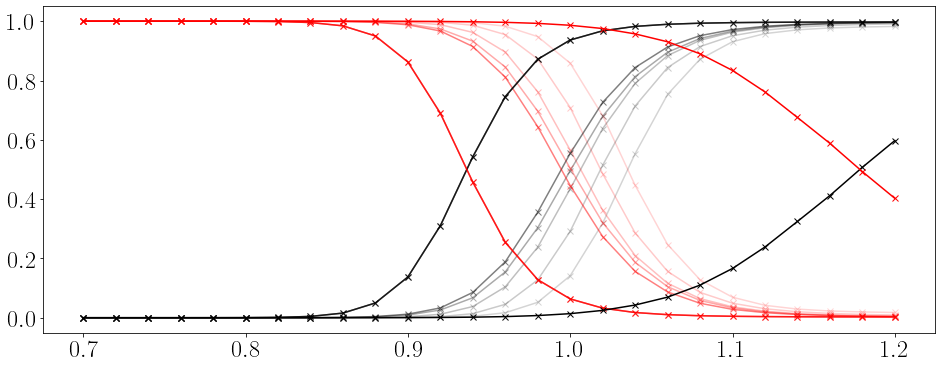

In [30]:
dlist = [0.7+0.02*i for i in range(26)]

# for n in [8]:

#     f2list = np.zeros(len(dlist))
#     f4list = np.zeros(len(dlist))
#     count = 0
#     for d in dlist:
#         with h5py.File('cpu/linear/dataN%s/tflow-d%.2f-Jz0.10-p0-cutoff300.00.h5' %(n,d),'r') as hf:
#             liom = np.array(hf.get('liom_all_bck'))
#             H = np.array(hf.get('H0'))
#             V = H - np.diag(np.diag(H))
#             err = np.median(np.array(hf.get('err')))
#             print(d,np.max(np.abs(V)),err)
# #         l4 = (liom[n**2::]).reshape(n,n,n,n)
# #         print(len(liom[:n**2]),len(liom[n**2:]))
#         squared = np.sum([i**2 for i in liom])
#         f2 = np.sum([i**2 for i in liom[:n**2]])/squared
#         f4 = np.sum([i**2 for i in liom[n**2:]])/squared
        
#         f2list[count] = f2
#         f4list[count] = f4

#         count += 1

# #     print(f2list)
# #     print(f4list)
                
#     plt.plot(dlist,f2list,'k--',alpha=n/24)
#     plt.plot(dlist,f4list,'r--',alpha=n/24)

    
# for n in [8]:

#     f2list = np.zeros(len(dlist))
#     f4list = np.zeros(len(dlist))
#     count = 0
#     for d in dlist:
#         with h5py.File('cpu/linear/dataN%s/tflow-d%.2f-Jz0.10-p0-cutoff3.00.h5' %(n,d),'r') as hf:
#             liom = np.array(hf.get('liom_all_fwd'))
#             H = np.array(hf.get('H0'))
#             V = H - np.diag(np.diag(H))
#             err = np.mean(np.array(hf.get('err')))
# #             print(d,np.max(np.abs(V)),err)
# #         l4 = (liom[n**2::]).reshape(n,n,n,n)
# #         print(len(liom[:n**2]),len(liom[n**2:]))
#         squared = np.sum([i**2 for i in liom])
#         f2 = np.sum([i**2 for i in liom[:n**2]])/squared
#         f4 = np.sum([i**2 for i in liom[n**2:]])/squared
        
#         f2list[count] = f2
#         f4list[count] = f4

#         count += 1

# #     print(f2list)
# #     print(f4list)
                
#     plt.plot(dlist,f2list,'ok--',alpha=n/24)
#     plt.plot(dlist,f4list,'or--',alpha=n/24)
    
for n in [8,12,16,24]:
    LIOM = 'fwd'
    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)

    f2list = np.zeros(len(dlist))
    f4list = np.zeros(len(dlist))
    count = 0
    for d in dlist:
        for x in xlist:
            for delta in Ulist:
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
#                     print(liom)
#                     liom4 = np.array(hf.get('liom4_fwd'))
                    liom2 = liom[0:n**2]
                    liom4 = liom[n**2:]
                    params = np.array(hf.get('params'))
#                     if d == 0.7:
#                         print(params)
                    H = np.array(hf.get('H2_diag'))
#                     err = np.median(np.array(hf.get('err')))
                    V = H - np.diag(np.diag(H))
#                     print(d,np.max(np.abs(V)),err)
                squared = np.sum([i**2 for i in liom2]) + np.sum([i**2 for i in liom4])
                f2 = np.sum([i**2 for i in liom2])/squared
                f4 = np.sum([i**2 for i in liom4])/squared

        f2list[count] = f2
        f4list[count] = f4

        count += 1
        
#     print(n,f2list)
#     print(n,f4list)

    plt.plot(dlist,f2list,'kx--',alpha=n/36)
    plt.plot(dlist,f4list,'rx--',alpha=n/36)
    
# plt.yscale('log')
plt.show()
plt.close()


flist2 = np.zeros((8,len(dlist)))
flist4 = np.zeros((8,len(dlist)))
ncount = 0
for n in [8,10,12,16,24,30,36,48]:
    LIOM = 'bck'
    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)

    f2list = np.zeros(len(dlist))
    f4list = np.zeros(len(dlist))
    count = 0
    for d in dlist:
        for x in xlist:
            for delta in Ulist:
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
#                     print(liom)
#                     liom4 = np.array(hf.get('liom4_fwd'))
                    liom2 = liom[0:n**2]
                    liom4 = liom[n**2:]
                    params = np.array(hf.get('params'))
#                     if d == 0.7:
#                         print(params)
                    H = np.array(hf.get('H2_diag'))
#                     err = np.median(np.array(hf.get('err')))
                    V = H - np.diag(np.diag(H))
                    if n == 48 or n ==8:
                        print(d,np.max(np.abs(V)))
                squared = np.sum([i**2 for i in liom2]) + np.sum([i**2 for i in liom4])
                f2 = np.sum([i**2 for i in liom2])/squared
                f4 = np.sum([i**2 for i in liom4])/squared

        f2list[count] = f2
        f4list[count] = f4

        count += 1
        
#     print(n,f2list)
#     print(n,f4list)

    plt.plot(dlist,f2list,'kx-',alpha=n/48)
    plt.plot(dlist,f4list,'rx-',alpha=n/48)
    
    flist2[ncount] = f2list
    flist4[ncount] = f4list
    ncount += 1

    
# plt.yscale('log')
plt.show()
plt.close()

In [17]:
import fssa

In [33]:
test=fssa.autoscale(np.array([8,10,12,16,24,30,36]),np.array(dlist)[5:30],flist2[0:-2,5:30],0.1*np.ones((flist2[0:-2,5:30]).shape),2.,2.,0.)
print(r'$\rho_c = $',test.rho)
print(float(test.rho), test.nu, test.zeta)
print('rho err',test.drho)
print('quality',test.fun)

test2=fssa.autoscale(np.array([8,10,12,16,24,30,36]),np.array(dlist)[5:30],flist4[0:-2,5:30],0.1*np.ones((flist4[0:-2,5:30]).shape),2.,1.,0.)
print(r'$\rho_c = $',test2.rho)
print(float(test2.rho), test2.nu, test2.zeta)
print('rho err',test2.drho)
print('quality',test2.fun)

ValueError: a should have shape (l.size, rho.size)

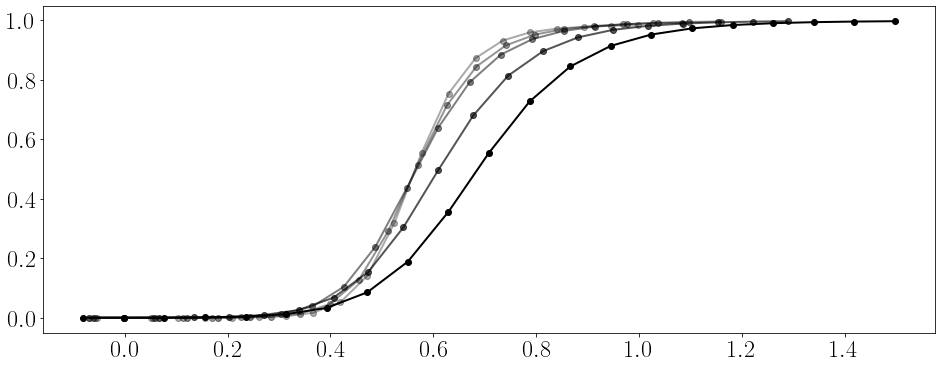

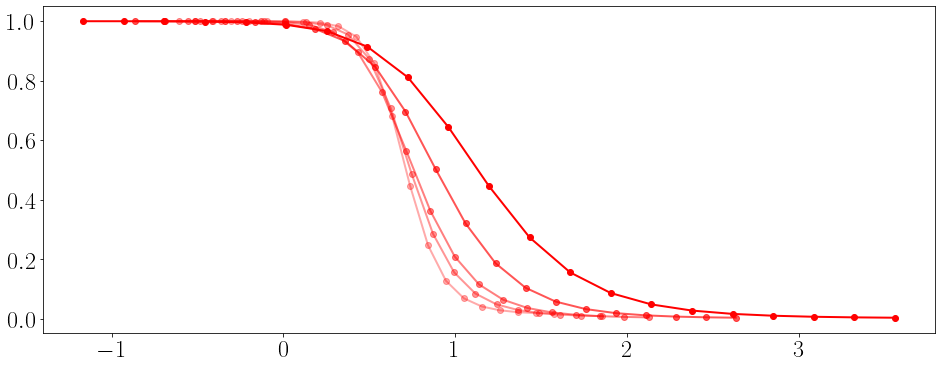

In [28]:
dc,lc=0,0
dis2=np.zeros(len(dlist[5:30]))
for L in [8,10,12,16,24]:
    dc=0
    for d in dlist[5:30]:
        dis2[dc] = L**(1/test.nu)*(dlist[5:30][dc]-test.rho)/test.rho
        dc += 1
    plt.plot(dis2,flist2[lc,5:30],'k-',alpha=L/24,linewidth='2',marker='o')
    lc += 1 
plt.show()
plt.close()

dc,lc=0,0
dis2=np.zeros(len(dlist[5:30]))
for L in [8,10,12,16,24]:
    dc=0
    for d in dlist[5:30]:
        dis2[dc] = L**(1/test2.nu)*(dlist[5:30][dc]-test2.rho)/test2.rho
        dc += 1
    plt.plot(dis2,flist4[lc,5:30],'r-',alpha=L/24,linewidth='2',marker='o')
    lc += 1 
plt.show()
plt.close()

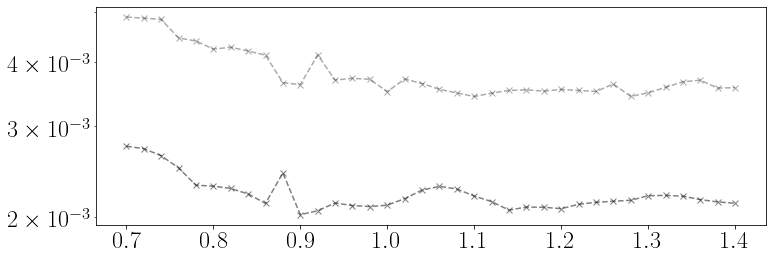

In [520]:
for n in [8,12]:
    LIOM = 'bck'
    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)

    errlist = np.zeros(len(dlist))
    count = 0
    for d in dlist:
        for x in xlist:
            for delta in Ulist:
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    err = np.array(hf.get('err'))
                    inv = np.array(hf.get('inv'))
#                 plt.plot(np.sort(err),'-o')
#                 plt.yscale('log')
#                 plt.show()
#                 plt.close()

        errlist[count] = np.median(err)

        count += 1
        
#     print(n,f2list)
#     print(n,f4list)

    plt.plot(dlist,errlist,'kx--',alpha=n/24)
plt.yscale('log')
plt.show()
plt.close()

In [481]:
n=8
# for d in [0.7]:
#     with h5py.File('cpu/linear/dataN%s/tflow-d%.2f-Jz0.10-p0-cutoff3.00.h5' %(n,d),'r') as hf:
#         liom = np.array(hf.get('liom_all_bck'))
#         print(np.max(np.abs(liom)))
#         l2 = (liom[0:n**2]).reshape(n,n)
    
#     plt.plot(range(n),np.log10(np.abs(np.diag(l2))))
    
LIOM = 'bck'
for d in [0.7]:
    for x in [0.0]:
        for delta in Ulist:
            if x == 0.0:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom2_fwd'))
                    print(liom)
                    err = np.array(hf.get('err'))
                print(np.max(np.abs(liom)))
                print(np.mean(err))
            liom = np.log10(np.abs(np.diag(liom)))
                
            plt.plot(liom,'r-',label=r'$\alpha= %.2f$' %x)
            
bessel = np.zeros(n)
for i in range(n):
    bessel[i] = np.log10(np.abs(jv(np.abs(i-n//2+1),2/0.7)**2))
plt.plot(bessel,'kx--',markersize='8')


plt.show()
plt.close()

None


TypeError: bad operand type for abs(): 'NoneType'

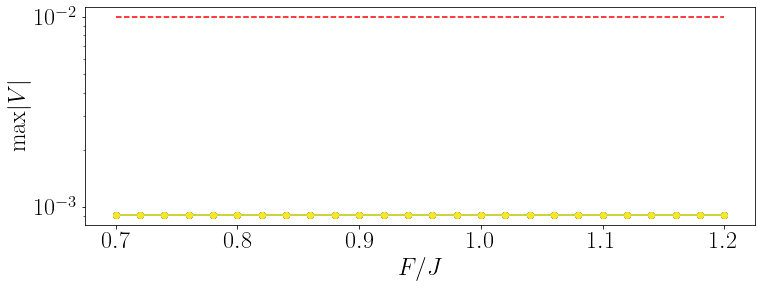

8 399.5165100097656
12 7555.17041015625
16 6341.908203125
24 6589.9033203125


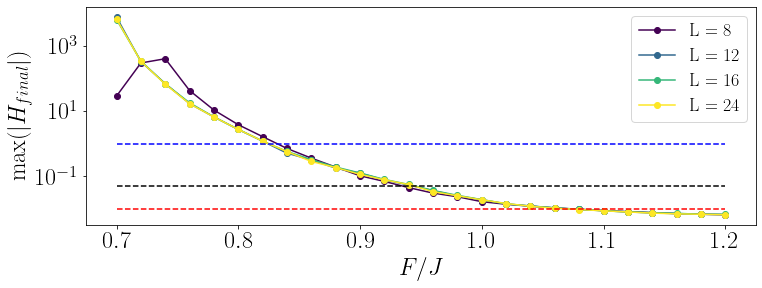

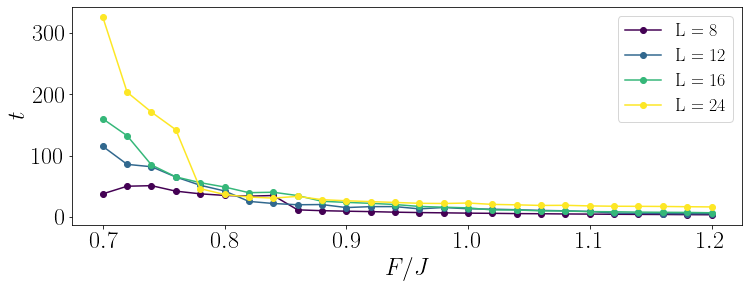

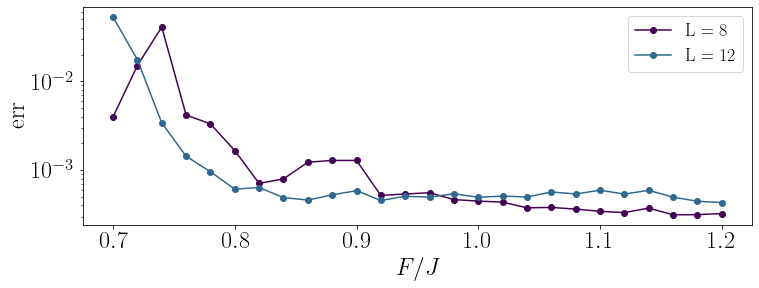

In [287]:
dis = [0.7+0.02*i for i in range(26)]
LIOM = 'bck'
nc = 4
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

for n in [8,12,16,24]:
    invlist = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        for x in [0.0]:
            for delta in Ulist:
                with h5py.File('cuda/linear/dataN%s/tflow-d%.2f-Jz0.10-p0-cutoff3.00.h5' %(n,d),'r') as hf:
                    inv = np.array(hf.get('H0'))
                    V = H0 - np.diag(np.diag(H0))
#                     print(d,np.max(np.abs(Hint)))
        invlist[dcount] = np.max(np.abs(V))
        dcount += 1
    plt.plot(dis,invlist,'o-')
#     plt.plot(dis,klist2,'x--')
plt.plot(dis,0.01*np.ones(len(dis)),'r--')
plt.yscale('log')
plt.xlabel(r'$F/J$')
plt.ylabel(r'$\textrm{max}|V|$')
plt.show()
plt.close()


for n in [8,12,16,24]:
    klist = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        count = 0
        count2 = 0
        for x in [0.0]:
            for delta in Ulist:
                with h5py.File('cuda/linear/dataN%s/tflow-d%.2f-Jz0.10-p0-cutoff3.00.h5' %(n,d),'r') as hf:
                    Hint = np.array(hf.get('Hint'))
                    Hint = Hint.reshape(n,n,n,n)
                for i in range(n):
                    for j in range(n):
                        Hint[i,i,j,j] = 0.
                        Hint[i,j,j,i] = 0.

        klist[dcount] = np.max(np.abs(Hint))
        dcount += 1
    plt.plot(dis,klist,'o-',label=r'L = %s' %n)
    print(n,np.max(klist))
#     plt.plot(dis,klist2,'x--')
plt.plot(dis,np.ones(len(dis)),'b--')
plt.plot(dis,.01*np.ones(len(dis)),'r--')
plt.plot(dis,.05*np.ones(len(dis)),'k--')
plt.legend(fontsize=18)
plt.xlabel(r'$F/J$')
plt.ylabel(r'$\textrm{max}(|H_{final}|)$')
plt.yscale('log')
plt.show()
plt.close()

for n in [8,12,16,24]:
    klist = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        count = 0
        count2 = 0
        for x in [0.0]:
            for delta in Ulist:
                with h5py.File('cuda/linear/dataN%s/tflow-d%.2f-Jz0.10-p0-cutoff3.00.h5' %(n,d),'r') as hf:
                    time = np.array(hf.get('time'))

        klist[dcount] = time/60
        dcount += 1
    plt.plot(dis,klist,'o-',label=r'L = %s' %n)

plt.legend(fontsize=18)
plt.xlabel(r'$F/J$')
plt.ylabel(r'$t$')
# plt.yscale('log')
plt.show()
plt.close()

for n in [8,12]:
    klist = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        count = 0
        count2 = 0
        for x in [0.0]:
            for delta in Ulist:
                with h5py.File('cuda/linear/dataN%s/tflow-d%.2f-Jz0.10-p0-cutoff3.00.h5' %(n,d),'r') as hf:
                    err = np.array(hf.get('err'))

        klist[dcount] = np.median(err)
        dcount += 1
    plt.plot(dis,klist,'o-',label=r'L = %s' %n)

plt.legend(fontsize=18)
plt.xlabel(r'$F/J$')
plt.ylabel(r'err')
plt.yscale('log')
plt.show()
plt.close()

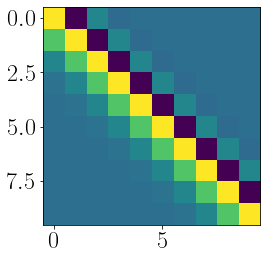

[[ 1.00000000e+00  5.00000000e-01  1.25000000e-01  2.08333333e-02
   2.60416667e-03  2.60416667e-04  2.17013882e-05  1.55010491e-06
   9.68470474e-08  5.51838586e-09]
 [-5.00000000e-01  7.50000000e-01  4.37500000e-01  1.14583333e-01
   1.95312500e-02  2.47395833e-03  2.49565958e-04  2.09264507e-05
   1.50099159e-06  9.68470474e-08]
 [ 1.25000000e-01 -4.37500000e-01  7.65625000e-01  4.40104167e-01
   1.14908854e-01  1.95638021e-02  2.47667076e-03  2.49761739e-04
   2.09264507e-05  1.55010491e-06]
 [-2.08333333e-02  1.14583333e-01 -4.40104167e-01  7.65190972e-01
   4.40049913e-01  1.14903429e-01  1.95633460e-02  2.47667076e-03
   2.49565958e-04  2.17013882e-05]
 [ 2.60416667e-03 -1.95312500e-02  1.14908854e-01 -4.40049913e-01
   7.65197753e-01  4.40050597e-01  1.14903429e-01  1.95638021e-02
   2.47395833e-03  2.60416667e-04]
 [-2.60416667e-04  2.47395833e-03 -1.95638021e-02  1.14903429e-01
  -4.40050597e-01  7.65197753e-01  4.40049913e-01  1.14908854e-01
   1.95312500e-02  2.60416667e-03

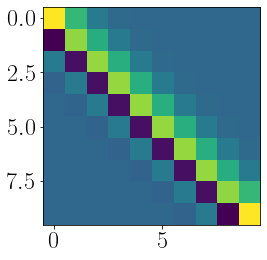

In [42]:
test = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        test[i,j] = jv(i-j,1)
plt.imshow(test)
plt.show()
plt.close()

print(np.linalg.inv(test))

plt.imshow(np.linalg.inv(test))
plt.show()
plt.close()

0.0


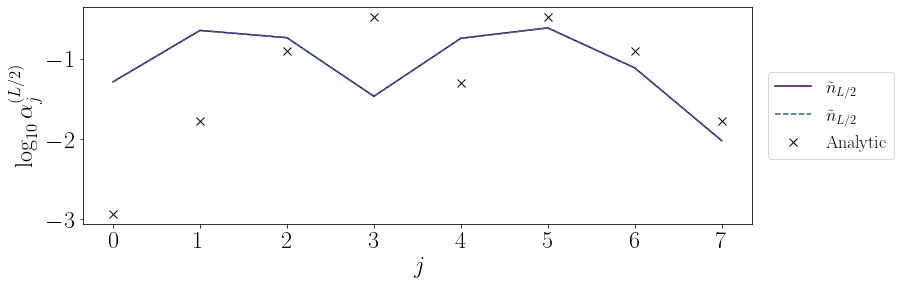

In [733]:
dis = [0.7]
xlist = [0.0]
dis_type='linear'
n = 8

norm = False
LIOM = 'bck'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('gpu/%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
#                 liom = np.array(hf.get('liom'))
#                 liom2 = liom[:n**2].reshape(n,n)
#                 liom4 = liom[n**2:].reshape(n,n,n,n)
#                 err = np.array(hf.get('err'))
#                 print(np.median(err))

                liom2 = np.array(hf.get('liom2'))
                liom4 = np.array(hf.get('liom4'))
                print(np.max(np.abs(liom4)))
                liom_diag = np.diag(liom2)
                liom4_diag = [liom4[i,i,i,i] for i in range(n)]
                liom_int_diag = liom_diag+liom4_diag
                
                liom2 = np.log10(np.abs(liom_diag))
                liomint = np.log10(np.abs(liom_int_diag))
                
            plt.plot(liom2,label=r'$\tilde{n}_{L/2}$')
            plt.plot(liomint,'--',label=r'$\tilde{n}_{L/2}$')

bessel = np.zeros(n)
for i in range(n):
    bessel[i] = np.log10(np.abs(jv(np.abs(i-n//2),2)**2))
plt.plot(bessel,'kx',markersize='8',label=r'Analytic')
plt.legend(loc='center right',bbox_to_anchor=(1.225,.5),fontsize=18)
# plt.ylim(-20,0)
plt.ylabel(r'$\log_{10} \alpha^{(L/2)}_j$')
plt.xlabel(r'$j$')
# plt.savefig('bessel2.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()
norm = False

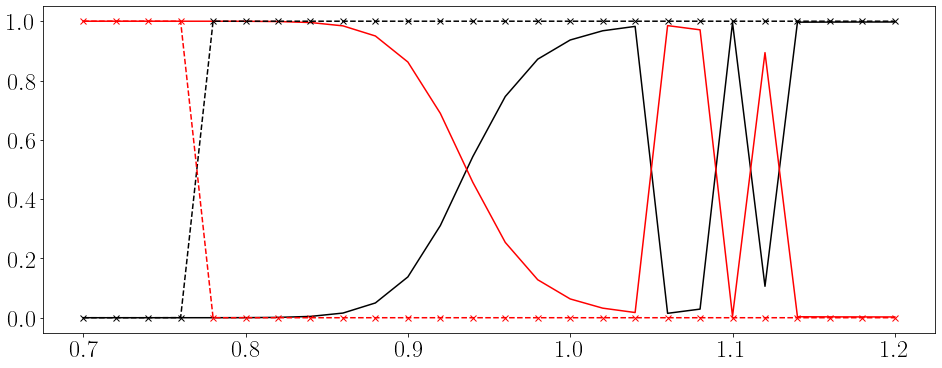

0.7 0.014418511 0.23123693 46645.965 1.0000155 95614660000.0
0.7 1.045881e-11 1.0
0.72 0.001167959 0.2268245 7264.9077 1.0000165 2446182700.0
0.72 4.0880693e-10 1.0
0.74 0.000995459 0.41722247 1159.8572 0.99996555 34751424.0
0.74 2.8774808e-08 1.0
0.76 0.0009962408 0.7367402 17.545832 1.0000091 6542.4995
0.76 0.00015282481 0.9998472
0.7799999999999999 0.0009989566 1.0 0.0 1.0 0.0
0.7799999999999999 1.0 0.0
0.7999999999999999 0.0009990921 1.0 0.0 1.0 0.0
0.7999999999999999 1.0 0.0
0.82 0.0009952987 1.0 0.0 1.0 0.0
0.82 1.0 0.0
0.84 0.0009955085 1.0 0.0 1.0 0.0
0.84 1.0 0.0
0.86 0.0009959122 1.0 0.0 1.0 0.0
0.86 1.0 0.0
0.8799999999999999 0.0009971692 1.0 0.0 1.0 0.0
0.8799999999999999 1.0 0.0
0.8999999999999999 0.0009981508 1.0 0.0 1.0 0.0
0.8999999999999999 1.0 0.0
0.9199999999999999 0.0009919031 1.0 0.0 1.0 0.0
0.9199999999999999 1.0 0.0
0.94 0.0009944817 1.0 0.0 1.0 0.0
0.94 1.0 0.0
0.96 0.0009946954 1.0 0.0 1.0 0.0
0.96 1.0 0.0
0.98 0.0009945277 1.0 0.0 1.0 0.0
0.98 1.0 0.0
1.0 0.00

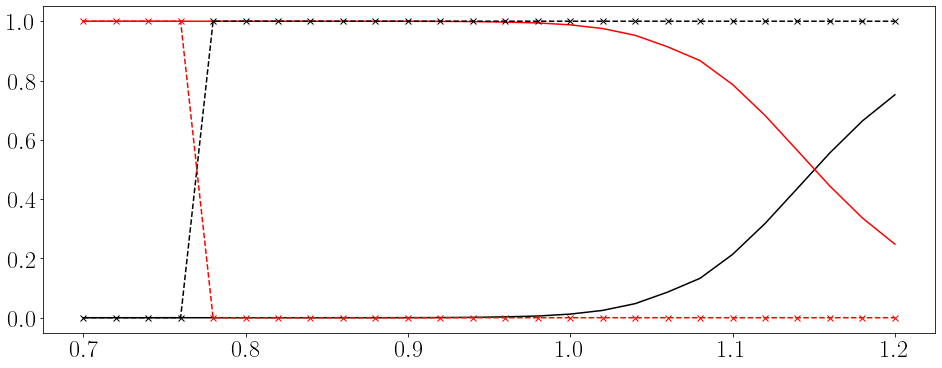

In [12]:
dlist = [0.7+0.02*i for i in range(26)]
nlist = [36]

flist2 = np.zeros((5,len(dlist)))
flist4 = np.zeros((5,len(dlist)))
ncount = 0
for n in nlist:
    LIOM = 'bck'
    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)

    f2list = np.zeros(len(dlist))
    f4list = np.zeros(len(dlist))
    count = 0
    for d in dlist:
        for x in xlist:
            for delta in Ulist:
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
#                     print(liom)
#                     liom4 = np.array(hf.get('liom4'))
                    liom2 = liom[0:n**2]
                    liom4 = liom[n**2:]
                    params = np.array(hf.get('params'))
#                     if d == 0.7:
#                         print(params)
                    H = np.array(hf.get('H2_diag'))
#                     err = np.median(np.array(hf.get('err')))
                    V = H - np.diag(np.diag(H))
#                     print(d,np.max(np.abs(V)),err)
                squared = np.sum([i**2 for i in liom2]) + np.sum([i**2 for i in liom4])
                f2 = np.sum([i**2 for i in liom2])/squared
                f4 = np.sum([i**2 for i in liom4])/squared

        f2list[count] = f2
        f4list[count] = f4

        count += 1
        
#     print(n,f2list)
#     print(n,f4list)

    plt.plot(dlist,f2list,'k-',alpha=n/36)
    plt.plot(dlist,f4list,'r-',alpha=n/36)
    
    flist2[ncount] = f2list
    flist4[ncount] = f4list
    ncount += 1

flist2 = np.zeros((5,len(dlist)))
flist4 = np.zeros((5,len(dlist)))
ncount = 0
for n in nlist:
    LIOM = 'bck'
    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)

    f2list = np.zeros(len(dlist))
    f4list = np.zeros(len(dlist))
    count = 0
    for d in dlist:
        for x in xlist:
            for delta in Ulist:
                with h5py.File('gpu/%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom2 = np.array(hf.get('liom2'))
#                     print(liom)
                    liom4 = np.array(hf.get('liom4'))
#                     liom2 = liom[0:n**2]
#                     liom4 = liom[n**2:]
                    params = np.array(hf.get('params'))
#                     if d == 0.7:
#                         print(params)
                    H = np.array(hf.get('H2_diag'))
#                     err = np.median(np.array(hf.get('err')))
                    V = H - np.diag(np.diag(H))
#                     print(d,np.max(np.abs(V)),err)
                squared = np.sum([i**2 for i in liom2]) + np.sum([i**2 for i in liom4])
                f2 = np.sum([i**2 for i in liom2])/squared
                f4 = np.sum([i**2 for i in liom4])/squared

        f2list[count] = f2
        f4list[count] = f4

        count += 1
        
#     print(n,f2list)
#     print(n,f4list)

    plt.plot(dlist,f2list,'kx--',alpha=n/36)
    plt.plot(dlist,f4list,'rx--',alpha=n/36)
    
    flist2[ncount] = f2list
    flist4[ncount] = f4list
    ncount += 1
    
# flist2 = np.zeros((5,len(dlist)))
# flist4 = np.zeros((5,len(dlist)))
# ncount = 0
# for n in [8,24]:
#     LIOM = 'bck'
#     nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)

#     f2list = np.zeros(len(dlist))
#     f4list = np.zeros(len(dlist))
#     count = 0
#     for d in dlist:
#         for x in xlist:
#             for delta in Ulist:
#                 with h5py.File('gpu2/linear/dataN%s/tflow-d%.2f-Jz%.2f-p%s-cutoff3.00.h5' %(n,d,delta,0),'r') as hf:
#                     liom = np.array(hf.get('liom_all_bck'))
# #                     print(liom)
# #                     liom4 = np.array(hf.get('liom4'))
#                     liom2 = liom[0:n**2]
#                     liom4 = liom[n**2:]
#                     params = np.array(hf.get('params'))
# #                     if d == 0.7:
# #                         print(params)
# #                     H = np.array(hf.get('H2_diag'))
# #                     err = np.median(np.array(hf.get('err')))
#                     V = H - np.diag(np.diag(H))
# #                     print(d,np.max(np.abs(V)),err)
#                 squared = np.sum([i**2 for i in liom2]) + np.sum([i**2 for i in liom4])
#                 f2 = np.sum([i**2 for i in liom2])/squared
#                 f4 = np.sum([i**2 for i in liom4])/squared

#         f2list[count] = f2
#         f4list[count] = f4

#         count += 1
        
# #     print(n,f2list)
# #     print(n,f4list)

#     plt.plot(dlist,f2list,'ko--',alpha=n/24)
#     plt.plot(dlist,f4list,'ro--',alpha=n/24)
    
#     flist2[ncount] = f2list
#     flist4[ncount] = f4list
#     ncount += 1

    
# plt.yscale('log')
plt.show()
plt.close()

# dlist = [0.7+0.02*i for i in range(26)]


flist2 = np.zeros((5,len(dlist)))
flist4 = np.zeros((5,len(dlist)))
ncount = 0
for n in nlist:
    LIOM = 'fwd'
    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)

    f2list = np.zeros(len(dlist))
    f4list = np.zeros(len(dlist))
    count = 0
    for d in dlist:
        for x in xlist:
            for delta in Ulist:
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
#                     print(liom)
#                     liom4 = np.array(hf.get('liom4'))
                    liom2 = liom[0:n**2]
                    liom4 = liom[n**2:]
                    params = np.array(hf.get('params'))
#                     if d == 0.7:
#                         print(params)
                    H = np.array(hf.get('H2_diag'))
#                     err = np.median(np.array(hf.get('err')))
                    V = H - np.diag(np.diag(H))
#                     print(d,np.max(np.abs(V)),err)
                squared = np.sum([i**2 for i in liom2]) + np.sum([i**2 for i in liom4])
                f2 = np.sum([i**2 for i in liom2])/squared
                f4 = np.sum([i**2 for i in liom4])/squared

        f2list[count] = f2
        f4list[count] = f4

        count += 1
        
#     print(n,f2list)
#     print(n,f4list)

    plt.plot(dlist,f2list,'k-',alpha=n/36)
    plt.plot(dlist,f4list,'r-',alpha=n/36)
    
    flist2[ncount] = f2list
    flist4[ncount] = f4list
    ncount += 1

flist2 = np.zeros((5,len(dlist)))
flist4 = np.zeros((5,len(dlist)))
ncount = 0
for n in nlist:
    LIOM = 'bck'
    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)

    f2list = np.zeros(len(dlist))
    f4list = np.zeros(len(dlist))
    count = 0
    for d in dlist:
        for x in xlist:
            for delta in Ulist:
                with h5py.File('gpu/%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom2 = np.array(hf.get('liom2_fwd'))
#                     print(liom)
                    liom4 = np.array(hf.get('liom4_fwd'))
#                     liom2 = liom[0:n**2]
#                     liom4 = liom[n**2:]
                    params = np.array(hf.get('params'))
#                     if d == 0.7:
#                         print(params)
                    H = np.array(hf.get('H2_diag'))
#                     err = np.median(np.array(hf.get('err')))
                    V = H - np.diag(np.diag(H))
                    print(d,np.max(np.abs(V)),np.max(np.abs(liom2)),np.max(np.abs(liom4)),np.sum([i**2 for i in liom2]),np.sum([i**2 for i in liom4]))
                squared = np.sum([i**2 for i in liom2]) + np.sum([i**2 for i in liom4])
                f2 = np.sum([i**2 for i in liom2])/squared
                f4 = np.sum([i**2 for i in liom4])/squared

        f2list[count] = f2
        f4list[count] = f4
        print(d,f2,f4)

        count += 1
        
#     print(n,f2list)
#     print(n,f4list)

    plt.plot(dlist,f2list,'kx--',alpha=n/36)
    plt.plot(dlist,f4list,'rx--',alpha=n/36)
    
    flist2[ncount] = f2list
    flist4[ncount] = f4list
    ncount += 1
    
# flist2 = np.zeros((5,len(dlist)))
# flist4 = np.zeros((5,len(dlist)))
# ncount = 0
# for n in [8,24]:
#     LIOM = 'bck'
#     nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)

#     f2list = np.zeros(len(dlist))
#     f4list = np.zeros(len(dlist))
#     count = 0
#     for d in dlist:
#         for x in xlist:
#             for delta in Ulist:
#                 with h5py.File('gpu2/linear/dataN%s/tflow-d%.2f-Jz%.2f-p%s-cutoff3.00.h5' %(n,d,delta,0),'r') as hf:
#                     liom = np.array(hf.get('liom_all_fwd'))
# #                     print(liom)
# #                     liom4 = np.array(hf.get('liom4'))
#                     liom2 = liom[0:n**2]
#                     liom4 = liom[n**2:]
#                     params = np.array(hf.get('params'))
# #                     if d == 0.7:
# #                         print(params)
# #                     H = np.array(hf.get('H2_diag'))
# #                     err = np.median(np.array(hf.get('err')))
#                     V = H - np.diag(np.diag(H))
# #                     print(d,np.max(np.abs(V)),err)
#                 squared = np.sum([i**2 for i in liom2]) + np.sum([i**2 for i in liom4])
#                 f2 = np.sum([i**2 for i in liom2])/squared
#                 f4 = np.sum([i**2 for i in liom4])/squared

#         f2list[count] = f2
#         f4list[count] = f4

#         count += 1
        
# #     print(n,f2list)
# #     print(n,f4list)

#     plt.plot(dlist,f2list,'ko--',alpha=n/24)
#     plt.plot(dlist,f4list,'ro--',alpha=n/24)
    
#     flist2[ncount] = f2list
#     flist4[ncount] = f4list
#     ncount += 1

    
# plt.yscale('log')
plt.show()
plt.close()